### Validation schema

In [1]:
# linear algebra
import numpy as np

#working with data in table structers
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt


# working with files
import sys
import os
from pathlib import Path
import csv

# to off warnings
import warnings
warnings.filterwarnings('ignore')

# validation schema 
import time
from datetime import timedelta, datetime
from sklearn.model_selection import TimeSeriesSplit
from collections import defaultdict
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform

# metrics  calculation
from sklearn.metrics import (
    mean_squared_error as mse_lib, 
    mean_absolute_error as mae_lib,
    mean_absolute_percentage_error as mape_lib,
    r2_score as r2_lib
)
from permetrics.regression import RegressionMetric

# advanced modeling
import optuna
import shap
shap.initjs()
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

# models
import random
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
import catboost as cb

### Read data

In [2]:
%%time
# get directory path
dirpath = Path(os.getcwd()).parent

# set the data path
train_test_data_path = Path(dirpath) / 'data' / 'train_test_data'

# initiate dict for data
data = {}

# load data to dict
for file_path in train_test_data_path.iterdir():
    if file_path.is_file():
        data[file_path.stem] = pd.read_csv(file_path)
        print(file_path.stem)

submission_data
submission_example
train_data
CPU times: total: 15 s
Wall time: 15.3 s


### Validation schema

In [16]:
"""
    The following indexes will be used:
        
        from train_data:
          date_block_num
          shop_id
          item_category_id
          item_id
          item_cnt_month
        
        from test_data:
            shop_id',
            'item_id',
            'ID'

    Concept:
        Apply expanding window validation (except last month - target of competition)
        Monthly predictions
"""

class Validation:
    def __init__(self,
                 train_data,
                 submission_data,
                 submission_example,
                 metrics=['RMSE', 'MAE', 'MAPE', 'sMAPE', 'R2'],
                 n_splits=5,
                 model=cb.CatBoostRegressor(iterations=35, verbose=10),
                 check_nans = True,
                 dropna = False,
                 check_infs = True, 
                 plot=True,
                 test_size=0.2,
                 validation_schema_plot=False
                ):
        self.train_data = train_data
        self.submission_data = submission_data
        self.submission_example = submission_example
        self.metrics = metrics
        self.n_splits = n_splits
        self.model = model
        self.plot = plot
        self.test_size = test_size
        if self.n_splits > 1:
            self.tscv = TimeSeriesSplit(n_splits=self.n_splits)

        # Check data for valid columns
        assert set([
                    'date_block_num',
                    'shop_id',
                    'item_id',
                    'item_cnt_month'
                   ]).issubset(train_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                   ]).issubset(submission_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                    'ID'
                    ]).issubset(submission_example.columns),\
                "Invalid data"
        
        # Check for valid variables and drop nans if necessary
        if dropna:
            self.train_data = self.train_data.dropna()
            self.submission_data = self.submission_data.dropna()
            
        if check_nans:
            assert self.train_data.isna().sum().sum() == 0, 'Train data have NaNs'
            assert self.submission_data.isna().sum().sum() == 0, 'Test data have NaNs'
        
        if check_infs:
            assert np.isfinite(self.train_data).sum().sum() != 0, 'Train data have Infs'
            assert np.isfinite(self.submission_data).sum().sum() != 0, 'Test data have Infs'    
        
        # Сheck for sorting by timeseries data
        amount_of_unsorted_rows = len(self.train_data) - (self.train_data.date_block_num.diff().fillna(0) >= 0).sum()
        if amount_of_unsorted_rows != 0:
            print(f"Data is not sorted by time ({amount_of_unsorted_rows} rows), it will be further sorted automatically")
            self.train_data = self.train_data.sort_values(by=['date_block_num'])
            
        # Split to X and y
        #self.X = self.train_data.drop(columns='item_cnt_month')
        #self.y = self.train_data[['item_id', 'shop_id', 'item_cnt_month']]
        
        # Validation process visualisation
        if validation_schema_plot:
            if self.plot and n_splits > 1:
                split_history = {
                    'Step': ["Step"+str(i) for i in range(1, self.n_splits+1)],
                    'Train Data': [], 
                    'Validation Data': []
                }
                self.tscv = TimeSeriesSplit(n_splits=self.n_splits)
                for train, val in self.tscv.split(self.train_data[['item_id', 'shop_id', 'item_cnt_month']]):    
                    split_history['Train Data'].append(train.max()-train.min())
                    split_history['Validation Data'].append(val.max()-val.min())
                df = pd.DataFrame(split_history)
                print(df)
                sns.set(style="whitegrid")
                plt.figure(figsize=(6, 5))
                sns.barplot(x='Step', y='Train Data', data=df, color='skyblue', label='Train Data')
                sns.barplot(x='Step', y='Validation Data', data=df, color='salmon', label='Validation Data', bottom=df['Train Data'])
                plt.title('Distribution of data for training and validation')
                plt.xlabel('Validation step')
                plt.ylabel('Data quantity')
                plt.legend(loc='upper right')
                plt.tight_layout()
                plt.show()
            
    def train_test_split(self):
        """
        Split on train/test data
        where test data will contain records by last month of input train_data
        """
        
        last_month = self.train_data.date_block_num.max()
        test_data = self.train_data[self.train_data.date_block_num == last_month]
        train_data = self.train_data[self.train_data.date_block_num != last_month]
        
        return train_data, test_data        
    
    
    def calculate_metrics(self, y_pred, y_true):
        """
        Return metrics of regression calculated on fitted model
        """
        
        metrics = {}
        
        metrics['RMSE'] = mse_lib(y_true=y_true, y_pred=y_pred, squared=True)
        metrics['MAE'] = mae_lib(y_true=y_true, y_pred=y_pred)
        metrics['MAPE'] = mape_lib(y_true=y_true, y_pred=y_pred)
        metrics['sMAPE'] = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
        metrics["R2"] = r2_lib(y_true=y_true, y_pred=y_pred)
        
        return metrics
    
    def predict_test(self):
        """
         Return predictions based on test dataset
        """
        # Split data step (train/test)
        
        train_data, test_data = self.train_test_split()
        
        # Data selection
        X_train, y_train = train_data.drop(columns=['item_cnt_month']),\
                           train_data.item_cnt_month
        X_test, y_test = test_data.drop(columns=['item_cnt_month']),\
                         test_data.item_cnt_month
        
        # Train model
        model = self.model
        model.fit(X_train, y_train)
        
        # Evaliation test step

        y_pred_test = model.predict(X_test)
        
        # Return metrcis from test
        return pd.DataFrame.from_dict(self.calculate_metrics(y_pred=y_pred_test, y_true=y_test), orient='index', columns=['Test metrics'])
    
    
    def validate(self, predictions_by_ID = True, val_type="score", train_val_error_plot=False):
        eval_report = {}
        train_errors = []
        val_errors = []
        is_boost = False

        # Build dataframe with metrics information
        metric_values = pd.MultiIndex.from_product([["step" + str(i) for i in range(1, self.n_splits+1)],
                              ['train', 'validation']],
                             names=['Steps', 'Train/Validation/Test'])
        metrics = ['RMSE', 'MAE', 'MAPE', 'sMAPE', 'R2']
        metrics_info = pd.DataFrame('-', metric_values, metrics)

        # Define model
        rng = np.random.RandomState(42)
        model = self.model
            
        if self.n_splits > 1:

            # Split data step (train/test)

            train_data, test_data = self.train_test_split()

            # Split train to X and y
            X = train_data.drop(columns='item_cnt_month')
            y = train_data[['item_id', 'shop_id', 'item_cnt_month']]

            # Evaluation loop
            step = 0
            for train, val in self.tscv.split(y):

                # Initialize steps and timer
                step += 1
                ts = time.time()

                # Split data step (train/validation)
                y_train, y_val = y.iloc[train].item_cnt_month, y.iloc[val].item_cnt_month
                X_train, X_val = X.iloc[train], X.iloc[val]


                # Train step
                if isinstance(model, sklearn.ensemble._forest.RandomForestRegressor):
                    model = self.model
                    model.fit(X_train, y_train)

                else:
                    is_boost=True

                    if isinstance(model, cb.core.CatBoostRegressor):
                        # Split
                        train_data = cb.Pool(X_train, label=y_train)
                        valid_data = cb.Pool(X_val, label=y_val)

                        # Train 
                        model.fit(train_data, eval_set=valid_data)

                        # Get error report
                        evals_result = model.get_evals_result()
                        train_error = evals_result['learn']['RMSE']
                        val_error = evals_result['validation']['RMSE']

                    if isinstance(model, XGBRegressor):
                        model = self.model
                        model.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_val, y_val)], verbose=25)

                        # Get error report
                        evals_result = model.evals_result()
                        train_error = evals_result['validation_0']['rmse']
                        val_error = evals_result['validation_1']['rmse']

                    if isinstance(model, lgb.sklearn.LGBMRegressor):
                        assert self.params is not None, "params is None"
                        train_data = lgb.Dataset(X_train, label=y_train)
                        valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
                        model.fit(X_train, y_train, eval_set=[(X_val, y_val), (X_train, y_train)])

                        # Get error report
                        evals_result = model.evals_result_
                        train_error = evals_result['training']['l2']
                        val_error = evals_result['valid_0']['l2']

                    
                    train_errors.append(train_error)
                    val_errors.append(val_error)
                    
                # Get predictions
                y_pred_val = model.predict(X_val)
                y_pred_train = model.predict(X_train)

                # Calculate time required for step
                time_info = time.time() - ts

                # Metrics calucaltion step
                metrics_info.loc[("step" + str(step), 'validation'), :] = self.calculate_metrics(y_pred=y_pred_val, y_true=y_val)
                metrics_info.loc[("step" + str(step), 'train'), :] = self.calculate_metrics(y_pred=y_pred_train, y_true=y_train)
            
            if is_boost and train_val_error_plot:
                # Calculate mean values and std for train and validation error
                mean_train_errors = np.mean(train_errors, axis=0)
                std_train_errors = np.std(train_errors, axis=0)
                mean_val_errors = np.mean(val_errors, axis=0)
                std_val_errors = np.std(val_errors, axis=0)

                # Visualize learning curve with confidence intervals
                plt.figure(figsize=(10, 6))
                plt.plot(mean_train_errors, label='Average Train Error', color='blue')
                plt.plot(mean_val_errors, label='Average Validation Error', color='orange')
                plt.fill_between(range(len(mean_train_errors)), mean_train_errors - std_train_errors, mean_train_errors + std_train_errors, color='lightblue', alpha=0.7)
                plt.fill_between(range(len(mean_val_errors)), mean_val_errors - std_val_errors, mean_val_errors + std_val_errors, color='lightsalmon', alpha=0.3)
                plt.xlabel('Iterations')
                plt.ylabel('RMSE Error')
                plt.legend()
                plt.title(f'{type(model)} Average Training and Validation Error with Confidence Intervals')
                plt.show()
            
            # Extract metric for validation score
            metric = metrics_info.loc(axis=0)[:, 'validation']['RMSE']
            
        elif self.n_splits==1:
            # Predict test and calculate score on it
            metrics_info = self.predict_test()
            metric = metrics_info.loc['RMSE', :]
        
        # Return result of validation        
        if val_type == "report":    
            return metrics_info
        elif val_type=="score":
            return np.asarray(metric).mean()

### Test validation class

In [4]:
test_many_splits = Validation(
                 train_data=data['train_data'],
                 submission_data=data['submission_data'],
                 submission_example=data['submission_example'],
                 n_splits=10,
                 model = RandomForestRegressor(max_depth=2, n_estimators=2, random_state=42, n_jobs=-1),
                 check_nans=True,
                 dropna = True
                )

Data is not sorted by time (5616 rows), it will be further sorted automatically


In [5]:
test_one_split = Validation(
                 train_data=data['train_data'],
                 submission_data=data['submission_data'],
                 submission_example=data['submission_example'],
                 n_splits=1,
                 model = RandomForestRegressor(max_depth=1, n_estimators=1, random_state=42, n_jobs=-1),
                 check_nans=True,
                 dropna = True
                )

Data is not sorted by time (5616 rows), it will be further sorted automatically


In [6]:
%%time
test_many_splits.validate(val_type="score")

CPU times: total: 27.3 s
Wall time: 16.8 s


3.0140691474426986

In [7]:
test_one_split.validate(val_type="score")

5.245559088956195

In [8]:
test_many_splits.validate(val_type="report")

RMSE  MAE                MAPE  sMAPE   R2
Steps  Train/Validation/Test                                          
step1  train                 0.69 0.38  782658443501256.88 189.03 0.44
       validation            0.90 0.41  757811895456149.75 188.37 0.32
step2  train                 0.74 0.38  776960078317118.00 185.87 0.42
       validation            5.43 0.38  732409651595571.38 187.42 0.46
step3  train                 1.29 0.47 1047335340830903.88 188.13 0.69
       validation            3.02 0.48 1041875358292002.38 187.69 0.75
step4  train                 1.47 0.48 1050550703969297.50 187.98 0.76
       validation            2.76 0.50 1051581768138059.00 188.15 0.80
step5  train                 1.67 0.48 1062343066630748.75 187.91 0.78
       validation            1.72 0.48 1063375926796474.62 188.02 0.75
step6  train                 1.61 0.48 1063689444458189.25 187.91 0.79
       validation            3.75 0.61 1025912884914452.38 186.62 0.75
step7  train                 1.89 0.51 1121382407370267.75 187.14 0.78
       validation            4.53 0.55 1127779556060565.50 186.96 0.38
step8  train                 1.85 0.49 1050049417734925.75 187.11 0.78
       validation            4.70 0.48 1079499066807482.75 187.90 0.17
step9  train                 2.18 0.49 1051102668065919.25 187.35 0.73
       validation            1.47 0.44 1067811131139625.25 188.42 0.82
step10 train                 2.25 0.50 1106653869221552.62 187.46 0.72
       validation            1.87 0.48 1117199684735516.00 187.99 0.84

In [9]:
test_one_split.validate(val_type="report")

,Test metrics
RMSE,5.25
MAE,0.50
MAPE,1165914671974308.25
sMAPE,187.93
R2,0.51


### Advanced modeling

In [17]:
class Pipeline:
    def __init__(self,
                 train_data,
                 submission_data,
                 submission_example,
                 metrics=['rmse'],
                 model=cb.CatBoostRegressor(iterations=35, silent=True),
                 check_nans = True,
                 dropna = False,
                 check_infs = True,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=False,
                 params = None,
                 optimizer="Grid",
                 selection_sample_size=None,
                 explainability_layer=False,
                 error_analysis_layer=False,
                 train_val_error_plot=False,
                 optimizer_iterations=20
                 ):
        self.train_data = train_data
        self.submission_data = submission_data
        self.submission_example = submission_example
        self.metrics = metrics
        self.model = model
        self.fitted_model = None
        self.predictions=None
        self.params = params
        self.optimal_hyperparametres = None
        self.important_features = None
        self.important_features_index = None
        self.selection_sample_size = selection_sample_size
        self.optimizer = optimizer
        self.optimizer_iterations = optimizer_iterations
        self.__feature_importance_layer__ = feature_importance_layer
        self.__hyperparametr_optimization_layer__=hyperparametr_optimization_layer
        self.__explainability_layer__=explainability_layer
        self.__error_analysis_layer__=error_analysis_layer
        self.selected_train_data=None
        self.selected_X=None
        self.selected_test_data=None
        self.train_val_error_plot = train_val_error_plot
        
        # Check data for valid columns
        assert set([
                    'date_block_num',
                    'shop_id',
                    'item_id',
                    'item_cnt_month'
                   ]).issubset(train_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                   ]).issubset(submission_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                    'ID'
                    ]).issubset(submission_example.columns),\
                "Invalid data"

        # Check for valid variables
        if dropna:
            self.train_data = self.train_data.dropna()
            self.submission_data = self.submission_data.dropna()
            
        if check_nans:
            assert self.train_data.isna().sum().sum() == 0, 'Train data have NaNs'
            assert self.submission_data.isna().sum().sum() == 0, 'Test data have NaNs'
        
        if check_infs:
            assert np.isfinite(self.train_data).sum().sum() != 0, 'Train data have Infs'
            assert np.isfinite(self.submission_data).sum().sum() != 0, 'Test data have Infs'
        
        # Сheck for sorting by timeseries data
        amount_of_unsorted_rows = len(self.train_data) - (self.train_data.date_block_num.diff().fillna(0) >= 0).sum()
        if amount_of_unsorted_rows != 0:
            print(f"Data is not sorted by time ({amount_of_unsorted_rows} rows), it will be further sorted automatically")
            self.train_data = self.train_data.sort_values(by=['date_block_num'])
        
         # Split to X and y
        self.X = self.train_data.drop(columns='item_cnt_month')
        self.y = self.train_data[['item_id', 'shop_id', 'item_cnt_month']]
        
        # Сolumns required for validation
        self.train_validation_features = [
                    'date_block_num',
                    'shop_id',
                    'item_id',
                    'item_cnt_month'
                   ]
        self.test_validation_features = [
                'shop_id',
                'item_id',
               ]
        self.test_X_features = [
                'shop_id',
                'item_id',
                'date_block_num'
               ]
        
             
    def train_test_split(self):
        """
        Split on train/test data
        where test data will contain records by last month of input train_data
        """
        
        last_month = self.train_data.date_block_num.max()
        test_data = self.train_data[self.train_data.date_block_num == last_month]
        train_data = self.train_data[self.train_data.date_block_num != last_month]
        
        return train_data, test_data        
    
    
    def calculate_metrics(self, y_pred, y_true):
        """
        Return metrics of regression calculated on fitted model
        """
        
        metrics = {}
        
        metrics['RMSE'] = mse_lib(y_true=y_true, y_pred=y_pred, squared=True)
        metrics['MAE'] = mae_lib(y_true=y_true, y_pred=y_pred)
        metrics['MAPE'] = mape_lib(y_true=y_true, y_pred=y_pred)
        metrics['sMAPE'] = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
        metrics["R2"] = r2_lib(y_true=y_true, y_pred=y_pred)
        
        return metrics
    
    
    # Predict sales for target month (November 2015)
    def predict_target(self):
        """
            Return target predictions in accordance with submission example
        """ 
        
        if self.__feature_importance_layer__:
            train_features = self.important_features.copy()
            train_features.extend(self.train_validation_features)
            train_data = self.train_data[train_features]
            
            test_features = self.important_features.copy()
            test_features.extend(self.test_validation_features)
            submission_data = self.submission_data[test_features]
            
            submission_example = self.submission_example
        else:
            train_data = self.train_data
            submission_data = self.submission_data
            submission_example = self.submission_example
        
        X_train, y_train = train_data.drop(columns=['item_cnt_month']), train_data.item_cnt_month.clip(0, 20)
        X_submission = submission_data
        X_submission['date_block_num'] = 34
        
        if self.optimal_hyperparametres:
            model = cb.CatBoostRegressor(**self.optimal_hyperparametres, verbose=35)
        elif self.params:
            model = cb.CatBoostRegressor(**self.params, verbose=35)
        else:
            model = self.model
        model.fit(X_train, y_train)
        
        # Get feature importance info and sort it
        feature_importance = model.get_feature_importance(prettified=True)
        feature_importance = feature_importance.sort_values(by='Importances', ascending=True)

         # Visualize importatnt features
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance['Feature Id'], feature_importance['Importances'])
        plt.title('Feature Importances')
        plt.xlabel('Importance')
        plt.show()
        
        # Save model fitting
        self.fitted_model = model.copy()
        self.predictions=model.predict(X_submission.values)
        
        result = X_submission.join(pd.DataFrame(index=X_submission.index, data=self.predictions,\
                                       columns=['item_cnt_month']))\
                                            [['item_id', 'shop_id', 'item_cnt_month']].\
                            merge(self.submission_example, on=['shop_id', 'item_id'], how='right')\
                .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID')
        result.item_cnt_month = result.item_cnt_month.clip(0, 20).fillna(0) 
        return result
    
    # Predict sales for target month (November 2015)
    def predict_test(self):
        """
            Return calculated metrics and test predictions in accordance with test dataset
        """ 
         # Split data step (train/test)
        
        train_data, test_data = self.train_test_split()
        
        if self.__feature_importance_layer__:
            train_features = self.important_features.copy()
            train_features.extend(self.train_validation_features)
            train_data = train_data[train_features]
            
            test_features = self.important_features.copy()
            test_features.extend(self.test_validation_features)
            test_data = test_data[test_features]
        
        X_train, y_train = train_data.drop(columns=['item_cnt_month']), train_data.item_cnt_month.clip(0, 20)
        X_test, y_test = test_data.drop(columns=['item_cnt_month']), test_data.item_cnt_month.clip(0, 20)
        
        if self.optimal_hyperparametres:
            model = cb.CatBoostRegressor(**self.optimal_hyperparametres, verbose=35)
        elif self.params:
            model = cb.CatBoostRegressor(**self.params, verbose=35)
        else:
            model = self.model
        model.fit(X_train, y_train)
        
        # Get feature importance info and sort it
        feature_importance = model.get_feature_importance(prettified=True)
        feature_importance = feature_importance.sort_values(by='Importances', ascending=True)

         # Visualize importatnt features
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance['Feature Id'], feature_importance['Importances'])
        plt.title('Feature Importances')
        plt.xlabel('Importance')
        plt.show()
        
        # Save model fitting
        self.fitted_model = model.copy()
        
        y_pred_test=model.predict(X_test.values)
         
        return pd.DataFrame.from_dict(self.calculate_metrics(y_pred=y_pred_test, y_true=y_test), orient='index', columns=['Test metrics'])
    
    
    def feature_importance_layer(self, selector="Boruta"):
        sample_size = self.selection_sample_size 
        if sample_size is None:
            sample_size = self.train_data.shape[0]
        if selector=="Boruta":
            from boruta import BorutaPy
            
            # Select sample of data
            X = self.train_data.dropna().drop(columns='item_cnt_month')[:sample_size]
            y = self.train_data.dropna()[:sample_size].item_cnt_month
            np.int = np.int_
            np.float = np.float_
            np.bool=np.bool_

            # Init selector
            feat_selector = BorutaPy(RandomForestRegressor(max_depth=7, n_estimators=50),
                                     n_estimators='auto', 
                                     verbose=2, 
                                     max_iter=20,
                                     random_state=42,
                                 )

            # Fit selector
            feat_selector.fit(X.values, y.values)

            # Extract usefull features
            self.important_features_index = feat_selector.support_
            self.important_features = self.X.columns[feat_selector.support_].tolist()
            
            # Save info about usefull/useless features
            feature_importance_report = {
                "important_columns": self.train_data.drop(columns=['item_cnt_month'])\
                                                                       .iloc[:, feat_selector.support_].columns,
                "unimportant_columns": self.train_data.drop(columns=['item_cnt_month'])\
                                                                       .iloc[:, ~feat_selector.support_].columns,
                "feature_importance_scores" : feat_selector.ranking_
            }
            
            return feature_importance_report
        
    def hyperparametr_optimization_layer(self, optimizer="Grid"):
        
        if self.__feature_importance_layer__:
            train_features = self.important_features.copy()
            train_features.extend(self.train_validation_features)
            train_data = self.train_data[train_features]
            
            test_features = self.important_features.copy()
            test_features.extend(self.test_validation_features)
            test_data = self.test_data[test_features]
            
            submission_example = self.submission_example
        else:
            train_data = self.train_data
            test_data = self.test_data
            submission_example = self.submission_example
        
        print(f"Count of using features {train_data.shape[1]}")
            
        if optimizer=="Optuna":
            
            # Optimization fucntion
            def objective(trial):
                params = {
                    "iterations": trial.suggest_int("iterations", 10, 250),
                    "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
                    "depth": trial.suggest_int("depth", 1, 5),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 2, log=True),
                    "subsample": trial.suggest_float("subsample", 0.05, 1.0),
                    "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
                }

                model = Validation(
                                 train_data,
                                 test_data,
                                 submission_example,
                                 n_splits=5,
                                 model = cb.CatBoostRegressor(**params, silent=True),
                                 check_nans=False,
                                 plot=False
                                )
                rmse = model.validate(val_type="score", train_val_error_plot=self.train_val_error_plot)
                return rmse
            
            study = optuna.create_study(direction='minimize')
            study.optimize(objective, n_trials=self.optimizer_iterations)
            
            print('Best hyperparameters:', study.best_params)
            print('Best RMSE:', study.best_value)
            
            return study.best_params
        
        if optimizer=="Hyperopt":
            
            # Optimization fucntion
            def objective(params):
            
                params['depth'] = int(params['depth'])

                # Model creation
                model = Validation(
                                train_data,
                                test_data,
                                submission_example,
                                n_splits=5,
                                model = cb.CatBoostRegressor(**params, silent=True),
                                check_nans=False,
                                plot=False
                          )

                # Calculate validation error
                return {'loss': model.validate(val_type="score", train_val_error_plot=self.train_val_error_plot), 'status': STATUS_OK}

            # Define space for hyperparameters tuning
            
            space = {
                "iterations": hp.randint("iterations", 10, 250),
                'depth': hp.quniform('depth', 2, 5, 1),
                'learning_rate': hp.loguniform('learning_rate', -3, 0),
                'l2_leaf_reg': hp.loguniform('l2_leaf_reg', 1e-3, 2),
                "subsample": hp.uniform("subsample", 0.05, 1.0),
                "colsample_bylevel": hp.uniform("colsample_bylevel", 0.05, 1.0),
                
            }

            # Trials for recording optimization process
            trials = Trials()

            # TPE optimizer
            best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=self.optimizer_iterations, trials=trials)

            # Print best parameters
            print("Best parameters:")
            print(best)

            # Get best params
            best_params = {**space_eval(space, best)}
            return best_params
            
        
    def explainability_layer(self, ind_pred_to_expl=5, pred_with_high_sales=True):
        if self.__feature_importance_layer__:
            train_features = self.important_features.copy()
            train_features.extend(['item_cnt_month'])
            #train_features.extend(self.train_validation_features)
            train_data = self.train_data[train_features]
            
            test_features = self.important_features.copy()
            test_features.extend(['shop_id', 'item_id'])
            test_data = self.test_data[test_features]
        else:
            train_data = self.train_data
            test_data = self.test_data
            
        if self.optimal_hyperparametres:
            model = cb.CatBoostRegressor(**self.optimal_hyperparametres, silent=True)
        elif self.params:
            model = cb.CatBoostRegressor(**self.params, silent=True)
        else:
            model = self.model
            
        model.fit(train_data.drop(columns='item_cnt_month'), train_data.item_cnt_month)

        explainer = shap.Explainer(model)
        shap_values = explainer(test_data)
        
        # visualize SHAP values aggregated by first all predictions
        
        shap.summary_plot(shap_values, plot_type='bar')
        shap.summary_plot(shap_values, plot_type='violin')

        # collect SHAP values by item_id/shop_id combinations
        shap_info = {}
        shap_values.data = np.nan_to_num(shap_values.data, nan=0)
        if self.__feature_importance_layer__:
            for i in range(len(shap_values)):
                shap_info[tuple([int(float_num) for float_num in shap_values[i].data[-2:]])] = shap_values[i]
        else:
            for i in range(len(shap_values)):
                shap_info[tuple([int(float_num) for float_num in shap_values[i].data[1:3]])] = shap_values[i]
                
        # select shops/items combinations
        submission_examples = []
        for i in range(data['submission_example'].shape[0]):
            submission_examples.append(tuple(data['submission_example'].iloc[i][1:3]) )

        # create dict with ID <-> shop_id, item_id connection
        ID_by_shop_item = {'ID': [int(i) for i in data['submission_example'].ID],
                'shop_id': [int(i) for i in data['submission_example'].shop_id],
                'item_id': [int(i) for i in data['submission_example'].item_id]}
        df = pd.DataFrame(ID_by_shop_item)
        ID_to_shop_item = dict(zip(df['ID'], zip(df['shop_id'], df['item_id'])))

        # select predictions with high sales
        preds = self.test_data.join(pd.DataFrame(index= self.test_data.index, data=model.predict(self.test_data),\
                                                   columns=['item_cnt_month']))\
                                                        [['item_id', 'shop_id', 'item_cnt_month']].\
                                        merge(data['submission_example'], on=['shop_id', 'item_id'], how='right')\
                            .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID').fillna(0)
        predictions_with_high_sales = preds.sort_values(by=['item_cnt_month'], ascending=False)[:100]

        if pred_with_high_sales==True:
            # visualize SHAP values for random submission predictions with high sales
            counter = 0
            while counter < ind_pred_to_expl:
                random_ID_with_high_sales = ID_to_shop_item\
                                            [predictions_with_high_sales.ID.sample().values[0]]
                if random_ID_with_high_sales in shap_info.keys():
                    counter +=1
                    shap.plots.waterfall(shap_info[random_ID_with_high_sales])

        else:
            # visualize SHAP values for random submission predictions
            counter = 0
            while counter < ind_pred_to_expl:   
                random_ID = ID_to_shop_item[int(preds.iloc[random.randint(0, preds.shape[0]-1)].ID)]
                if random_ID in shap_info.keys():
                    counter +=1
                    shap.plots.waterfall(shap_info[random_ID_with_high_sales])
        
    def error_analysis_layer(self):
        error_analysis_report = []
        
        X = self.X
        y = self.y.item_cnt_month

        #spit traind data 
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, shuffle=False) 

        # learn model on train
        if self.optimal_hyperparametres:
            model = cb.CatBoostRegressor(**self.optimal_hyperparametres, silent=True)
        elif self.params:
            model = cb.CatBoostRegressor(**self.params, silent=True)
        else:
            model = self.model
            
        model.fit(X_train, y_train)

        # predict y_test
        y_pred = model.predict(X_test)
        
        #calculate error
        errors_info = pd.DataFrame({"y_pred": y_pred,
                                    "y_test": y_test, 
                                    "error": np.abs(y_pred-y_test),
                                    }).join(X_test)
        
        # adding 2 features for error analysis (one for small dynamic and another for big)
        errors_info['y_pred'] = round(errors_info.y_pred)
        errors_info[['y_pred', 'y_test']] = errors_info[['y_pred', 'y_test']].replace(0, 1)
        errors_info["error_type_1"] =  np.abs(errors_info.y_pred/errors_info.y_test)
        errors_info["error_type_2"] =  np.abs(errors_info.y_test/errors_info.y_pred)

        # k is the boundary separation coefficient based on the ratio of the predicted to the origin
        k = 10
        high_error_predictions = errors_info.sort_values(by=['error'], ascending=False).head(100)
        small_dynamic_is_poorly_predicted = errors_info[errors_info.error_type_1 > k].sort_values(by=['error_type_1'], ascending=False)
        big_target_is_poorly_predicted = errors_info[errors_info.error_type_2 > k].sort_values(by=['error_type_2'], ascending=False)
        percentage_of_big_small_poor_predictions = (errors_info[errors_info.error_type_1 > k].shape[0]\
                                                    + errors_info[errors_info.error_type_2 > k].shape[0])\
                                                    / X_test.shape[0] * 100
        items_most_often_errors_occur = {"small_dynamic": small_dynamic_is_poorly_predicted.groupby('item_id')['error']\
                                             .count()[small_dynamic_is_poorly_predicted.groupby('item_id')['error']\
                                             .count().sort_values(ascending=False) > 10].sort_values(ascending=False).index,
                                         "big_dynamic": big_target_is_poorly_predicted.groupby('item_id')['error']\
                                             .count()[big_target_is_poorly_predicted.groupby('item_id')['error']\
                                             .count().sort_values(ascending=False) > 10].sort_values(ascending=False).index
                                        }

        error_analysis_report = {
            "high_error_predictions": high_error_predictions,
            "poorly_small_dynamic": small_dynamic_is_poorly_predicted,
            "poorly_high_dynamic": big_target_is_poorly_predicted, 
            "percentage_of_big_small_poor_predictions" : f"{percentage_of_big_small_poor_predictions} %",
            "items_most_often_errors_occur": items_most_often_errors_occur
        }

        
        return error_analysis_report
    
    
    def evaluate(self):
        # Split data step (train/test)
        
        self.train_data, self.test_data = self.train_test_split()
        
        # Build pipeline
        if self.__feature_importance_layer__:
            feature_importance_report = self.feature_importance_layer()
        if self.__hyperparametr_optimization_layer__:
            self.optimal_hyperparametres = self.hyperparametr_optimization_layer(optimizer=self.optimizer)
            predictions = self.predict_target()
        else:
            predictions = self.predict_target()
        
        if self.__explainability_layer__:
            self.explainability_layer()
            
        if self.__error_analysis_layer__:
            error_analysis_report = self.error_analysis_layer()
            
        test_metrics = self.predict_test()
        
        # Retrurn results of evaluation
        if self.__feature_importance_layer__ and self.__error_analysis_layer__:
            return feature_importance_report, error_analysis_report, predictions, test_metrics
        elif self.__feature_importance_layer__:
            return feature_importance_report, predictions, test_metrics
        elif self.__error_analysis_layer__:
            return error_analysis_report, predictions, test_metrics
        else:
            return predictions, test_metrics

Test predict test fucntuion

In [15]:
test_predict_test = Pipeline(train_data=data['train_data'],
                 submission_data=data['submission_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(iterations=35, verbose=10, random_state=42),
                 check_nans=False,
                 explainability_layer = True
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically


Learning rate set to 0.5
0:	learn: 1.0568436	total: 1.1s	remaining: 37.3s
10:	learn: 0.9268174	total: 6.55s	remaining: 14.3s
20:	learn: 0.9043549	total: 11.8s	remaining: 7.85s
30:	learn: 0.8957515	total: 16.9s	remaining: 2.18s
34:	learn: 0.8927400	total: 19.1s	remaining: 0us


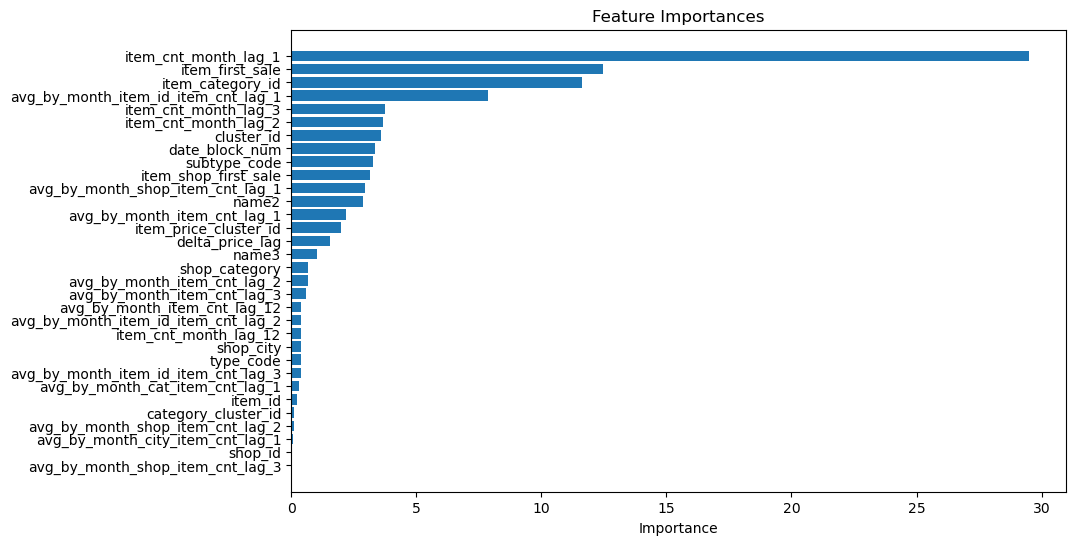

(<Axes: ylabel='Count'>,
             Test metrics
 RMSE                0.82
 MAE                 0.31
 MAPE  608251301483268.12
 sMAPE             187.68
 R2                  0.36)

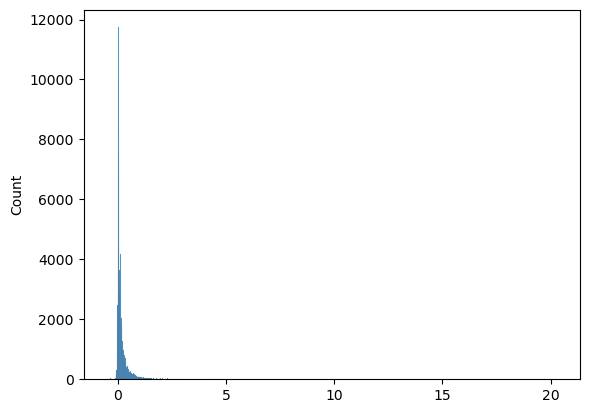

In [14]:
test_predict_test.predict_test()

Check how distribution will change if we not use clip for our data

In [17]:
predict_test_without_clip = Pipeline(train_data=data['train_data'],
                 submission_data=data['submission_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(iterations=35, verbose=10, random_state=42),
                 check_nans=False,
                 explainability_layer = True
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically


Learning rate set to 0.5
0:	learn: 1.7710063	total: 802ms	remaining: 27.3s
10:	learn: 1.4074887	total: 5.86s	remaining: 12.8s
20:	learn: 1.3563235	total: 10.5s	remaining: 7.03s
30:	learn: 1.3237020	total: 15.2s	remaining: 1.96s
34:	learn: 1.3096668	total: 17.2s	remaining: 0us


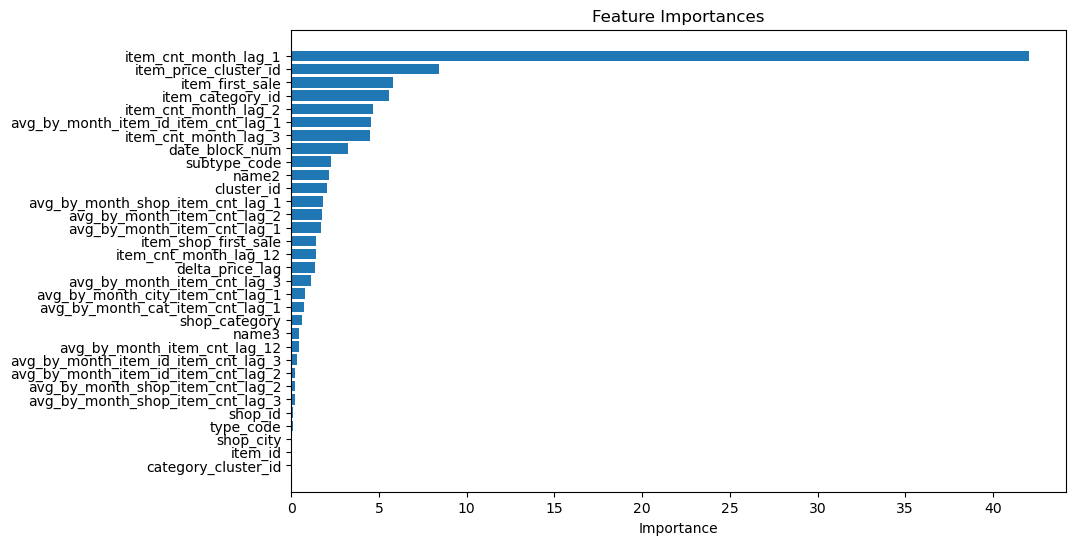

(<Axes: ylabel='Count'>,
             Test metrics
 RMSE                1.35
 MAE                 0.32
 MAPE  614961352792171.25
 sMAPE             187.92
 R2                  0.72)

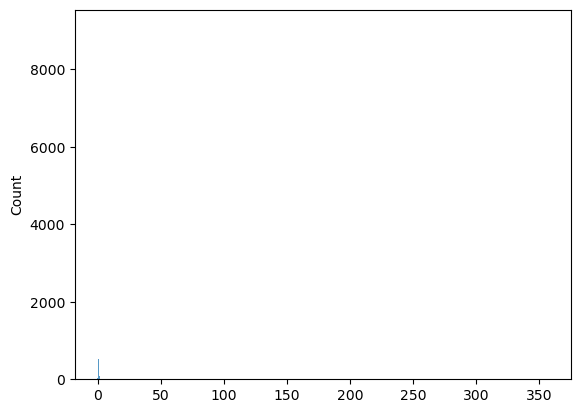

In [18]:
predict_test_without_clip.predict_test()

Compare feature importance plot with shap values for all predictions

In [33]:
%%time
test = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(iterations=35, verbose=10, random_state=42),
                 check_nans=False,
                 explainability_layer = True
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 6.84 s
Wall time: 8.06 s


Learning rate set to 0.5
0:	learn: 1.7660317	total: 750ms	remaining: 25.5s
10:	learn: 1.4055139	total: 5.39s	remaining: 11.8s
20:	learn: 1.3568584	total: 9.92s	remaining: 6.61s
30:	learn: 1.3155660	total: 14.6s	remaining: 1.88s
34:	learn: 1.3089643	total: 16.4s	remaining: 0us


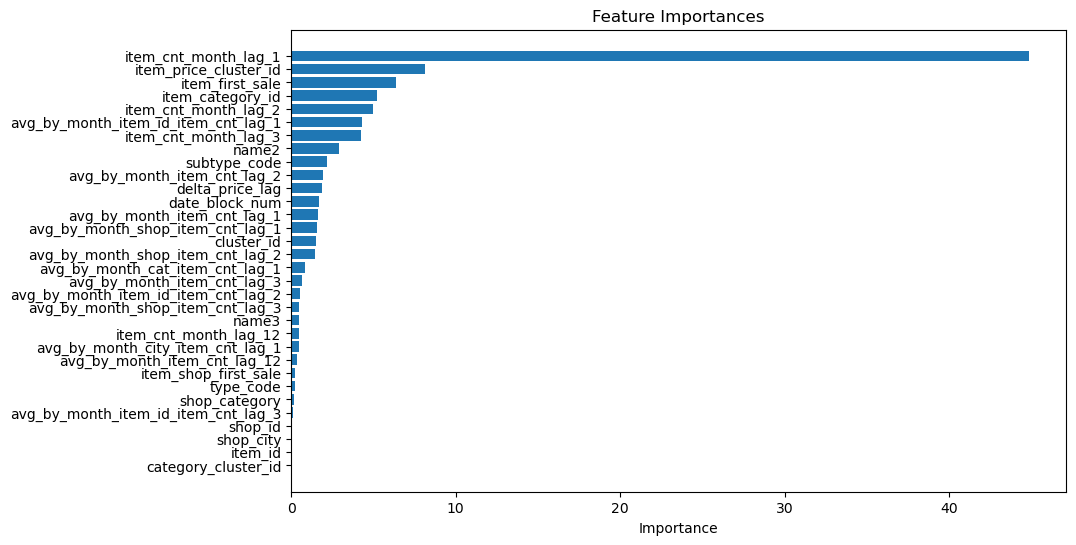

Learning rate set to 0.5
0:	learn: 1.7660317	total: 488ms	remaining: 16.6s
10:	learn: 1.4055139	total: 5.24s	remaining: 11.4s
20:	learn: 1.3568584	total: 9.88s	remaining: 6.58s
30:	learn: 1.3155660	total: 14.5s	remaining: 1.87s
34:	learn: 1.3089643	total: 16.3s	remaining: 0us


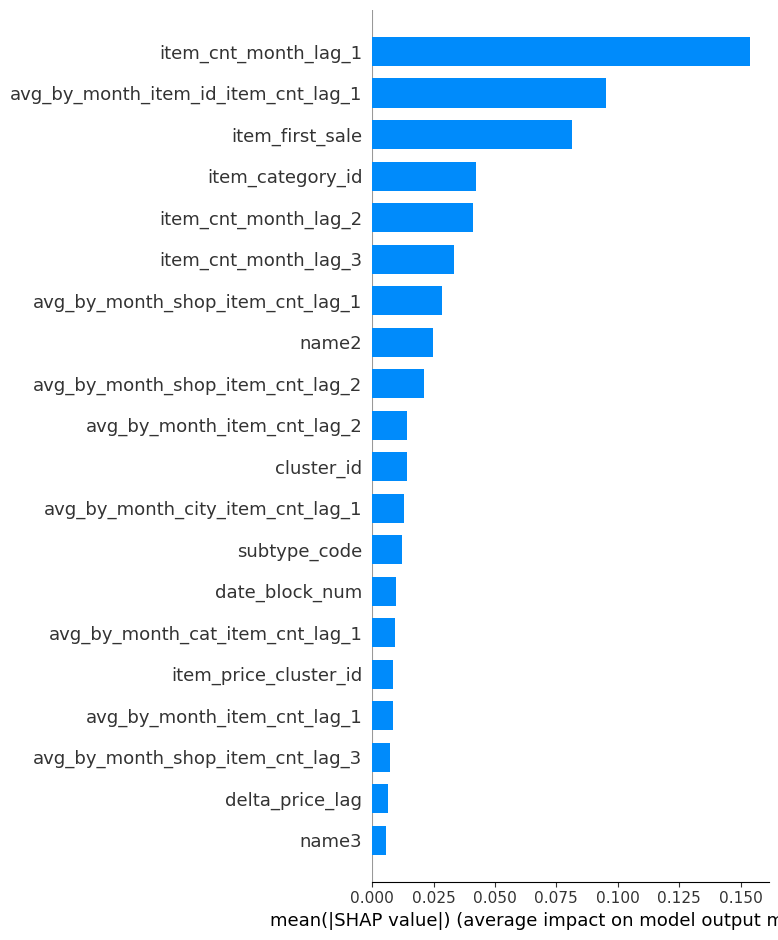

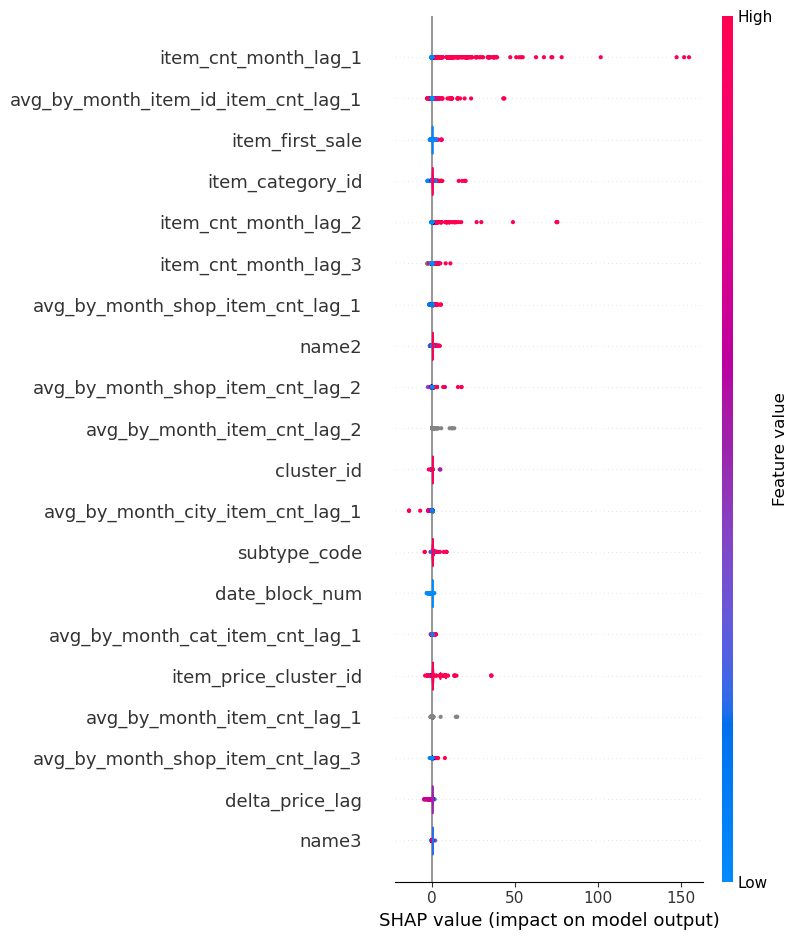

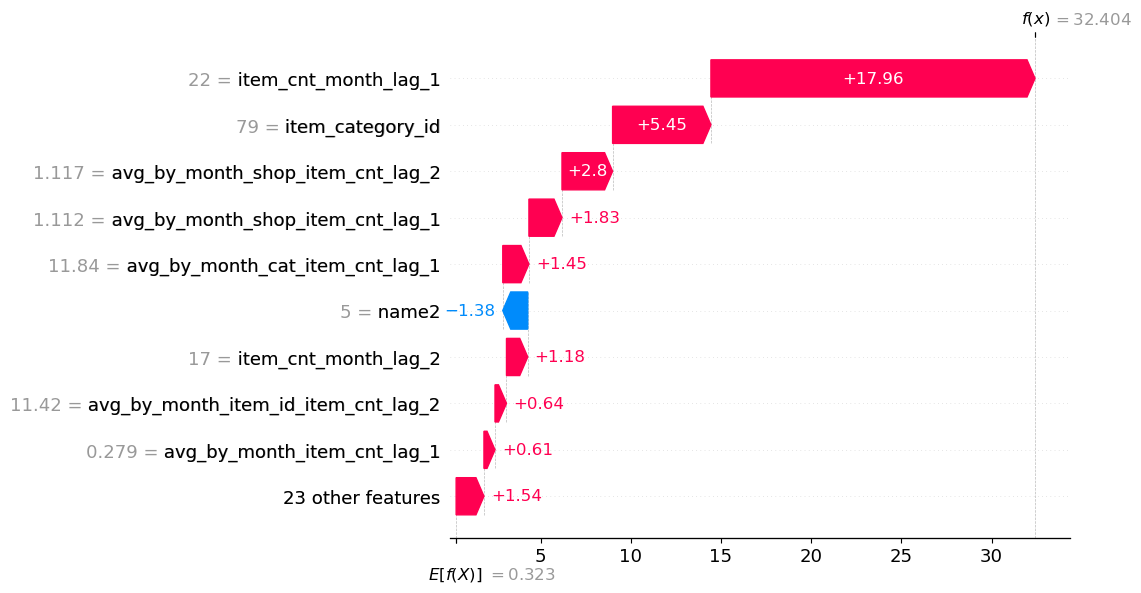

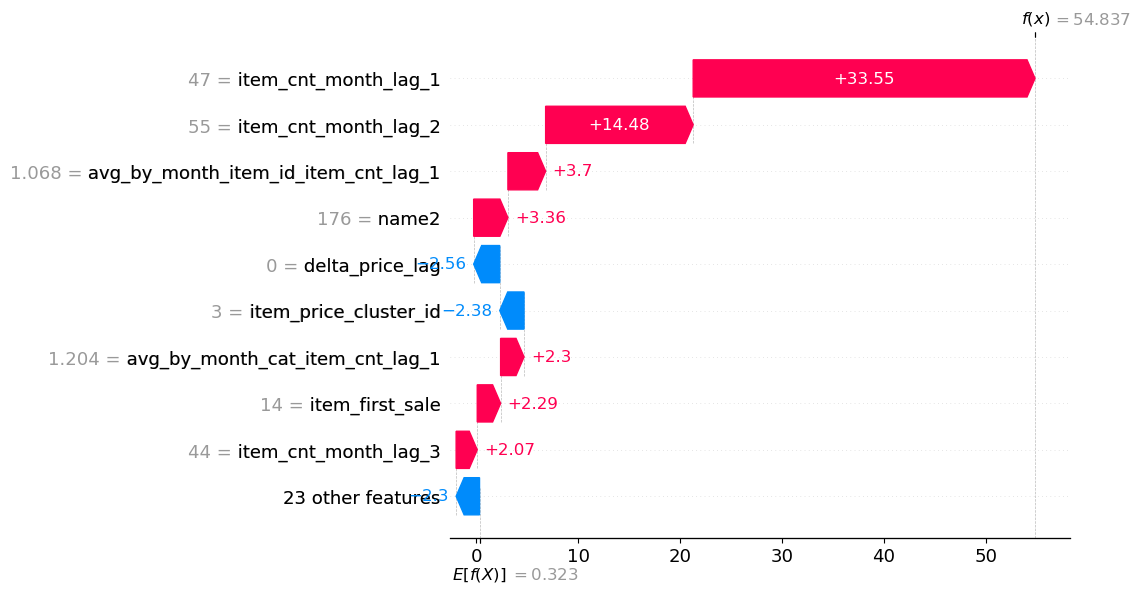

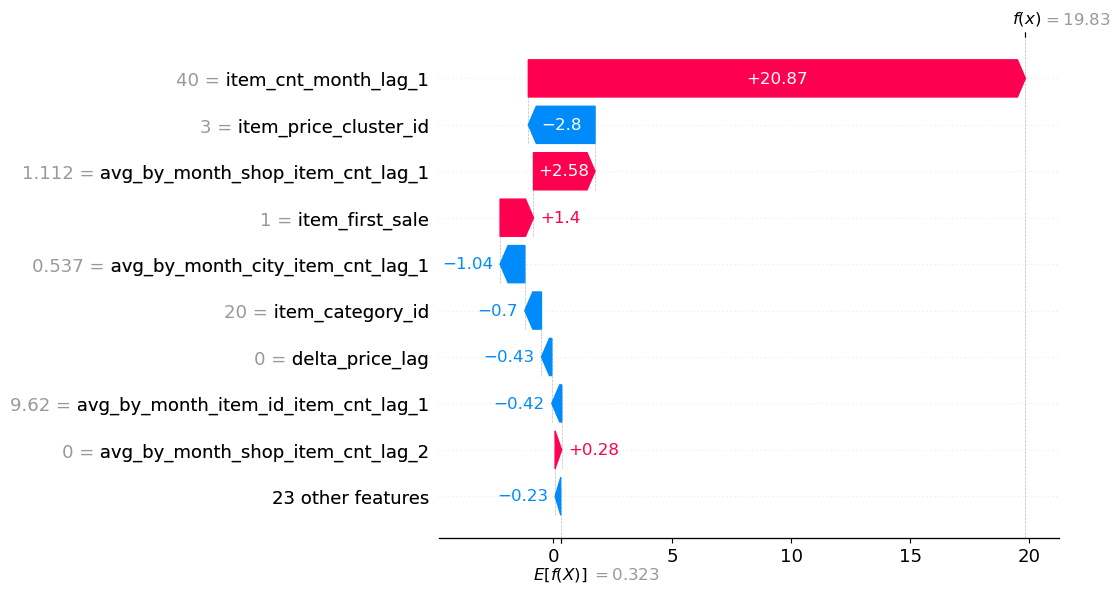

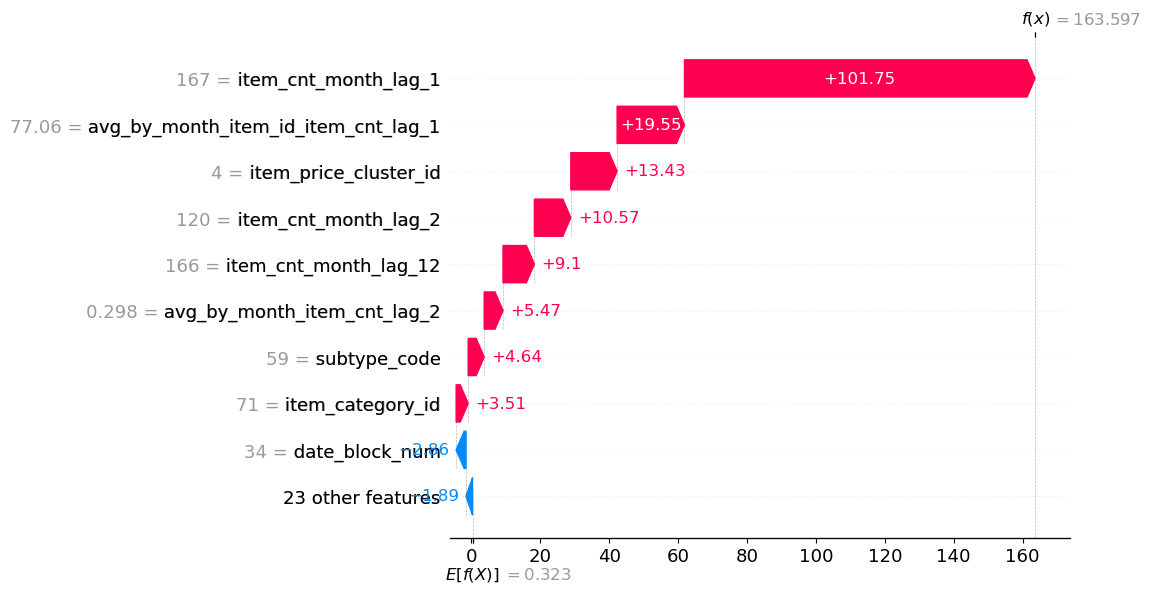

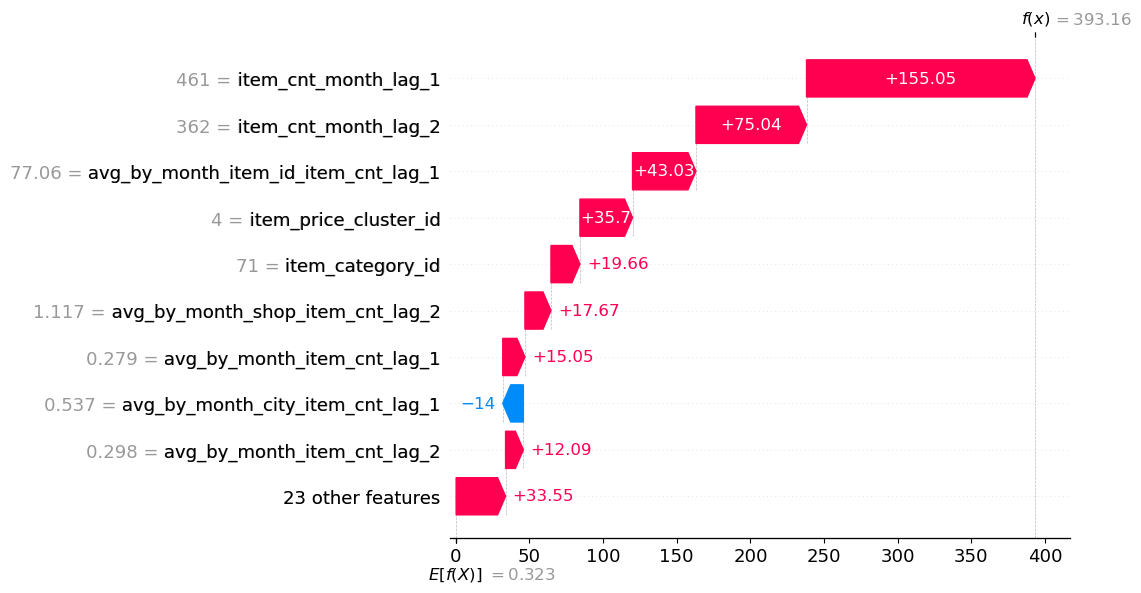

,ID,item_cnt_month
0,0,0.19
1,1,0.00
2,2,0.94
3,3,0.24
4,4,0.00
...,...,...
214195,214195,0.18
214196,214196,0.09
214197,214197,0.03
214198,214198,0.01


In [34]:
test.evaluate()

#### Feature selection layer test

In [5]:
%%time
CatBoostTestBoruta = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(iterations=35, verbose=10, random_state=42),
                 check_nans=False,
                 feature_importance_layer=True,
                 selection_sample_size=1000
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 3.09 s
Wall time: 3.53 s


In [6]:
%%time
feature_importance_report, boruta_test_submission = CatBoostTestBoruta.evaluate()

Iteration: 	1 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	2 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	3 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	4 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	5 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	6 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	7 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	8 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	9 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	10 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	11 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	12 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	13 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	14 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	15 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	16 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	17 / 

In [7]:
feature_importance_report

{'important_columns': Index(['item_cnt_month_lag_1', 'item_cnt_month_lag_12',
        'avg_by_month_item_id_item_cnt_lag_1'],
       dtype='object'),
 'unimportant_columns': Index(['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'type_code',
        'subtype_code', 'shop_city', 'shop_category', 'name2', 'name3',
        'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
        'avg_by_month_item_cnt_lag_1', 'avg_by_month_item_cnt_lag_2',
        'avg_by_month_item_cnt_lag_3', 'avg_by_month_item_cnt_lag_12',
        'avg_by_month_item_id_item_cnt_lag_2',
        'avg_by_month_item_id_item_cnt_lag_3',
        'avg_by_month_shop_item_cnt_lag_1', 'avg_by_month_shop_item_cnt_lag_2',
        'avg_by_month_shop_item_cnt_lag_3', 'avg_by_month_city_item_cnt_lag_1',
        'avg_by_month_cat_item_cnt_lag_1', 'delta_price_lag',
        'category_cluster_id', 'item_price_cluster_id', 'cluster_id',
        'item_shop_first_sale', 'item_first_sale'],
       dtype='object'),
 'feature_impor

#### Hyperparameters optimization layer test

In [8]:
%%time
CatBoostTestOptuna = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(random_state=42),
                 check_nans=False,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=True,
                 optimizer="Optuna",
                 optimizer_iterations = 1,
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 4.7 s
Wall time: 5.06 s


In [9]:
# %%time
optuna_test_submission = CatBoostTestOptuna.evaluate()

[I 2023-10-13 12:06:25,236] A new study created in memory with name: no-name-2f1872d3-bf40-4db1-998a-e3d3e780023f


Count of using features 33


[I 2023-10-13 12:08:55,188] Trial 0 finished with value: 1.4930650102863385 and parameters: {'iterations': 135, 'learning_rate': 0.038775695698556926, 'depth': 7, 'l2_leaf_reg': 0.0027088481038378535, 'subsample': 0.17918655049428245, 'colsample_bylevel': 0.8484310281408886}. Best is trial 0 with value: 1.4930650102863385.


Best hyperparameters: {'iterations': 135, 'learning_rate': 0.038775695698556926, 'depth': 7, 'l2_leaf_reg': 0.0027088481038378535, 'subsample': 0.17918655049428245, 'colsample_bylevel': 0.8484310281408886}
Best RMSE: 1.4930650102863385
0:	learn: 2.2110355	total: 415ms	remaining: 55.6s
35:	learn: 1.5318232	total: 13.3s	remaining: 36.7s
70:	learn: 1.4213492	total: 25.7s	remaining: 23.1s
105:	learn: 1.3793052	total: 38.1s	remaining: 10.4s
134:	learn: 1.3556969	total: 49.1s	remaining: 0us


In [10]:
%%time

CatBoostTestHyperopt = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(verbose=35, random_state=42),
                 check_nans=False,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=True,
                 optimizer="Hyperopt",
                 optimizer_iterations = 1,
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 4.52 s
Wall time: 6.07 s


In [11]:
%%time
hyperopt_test_submission = CatBoostTestHyperopt.evaluate()

Count of using features 33
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:15<00:00, 195.11s/trial, best loss: 1.5356921341810588]
Best parameters:
{'colsample_bylevel': 0.921473744966317, 'depth': 2.0, 'iterations': 161, 'l2_leaf_reg': 1.1580368692366803, 'learning_rate': 0.26157590994243807, 'subsample': 0.974127361789101}
0:	learn: 2.0546238	total: 444ms	remaining: 1m 11s
35:	learn: 1.4686705	total: 14.6s	remaining: 50.7s
70:	learn: 1.4431846	total: 28.7s	remaining: 36.4s
105:	learn: 1.4297553	total: 44s	remaining: 22.8s
140:	learn: 1.4209084	total: 58.2s	remaining: 8.25s
160:	learn: 1.4152976	total: 1m 6s	remaining: 0us
CPU times: total: 21min 59s
Wall time: 4min 26s


In [18]:
hyperopt_test_submission.describe()

,ID,item_cnt_month
count,214200.00,214200.00
mean,107099.50,0.25
std,61834.36,0.76
min,0.00,0.00
25%,53549.75,0.04
50%,107099.50,0.08
75%,160649.25,0.22
max,214199.00,20.00


#### Explainability layer Test

In [12]:
%%time
CatBoostSHAPTest = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(iterations=35, verbose=10, random_state=42),
                 check_nans=False,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=False,
                 explainability_layer=True
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 6.33 s
Wall time: 7.79 s


Learning rate set to 0.5
0:	learn: 1.7660317	total: 777ms	remaining: 26.4s
10:	learn: 1.4027484	total: 6.38s	remaining: 13.9s
20:	learn: 1.3564015	total: 11.5s	remaining: 7.67s
30:	learn: 1.3225926	total: 16.4s	remaining: 2.12s
34:	learn: 1.3104957	total: 18.6s	remaining: 0us
Learning rate set to 0.5
0:	learn: 1.7660317	total: 1.28s	remaining: 43.6s
10:	learn: 1.4027484	total: 6.45s	remaining: 14.1s
20:	learn: 1.3564015	total: 11.5s	remaining: 7.66s
30:	learn: 1.3225926	total: 16.4s	remaining: 2.11s
34:	learn: 1.3104957	total: 18.5s	remaining: 0us


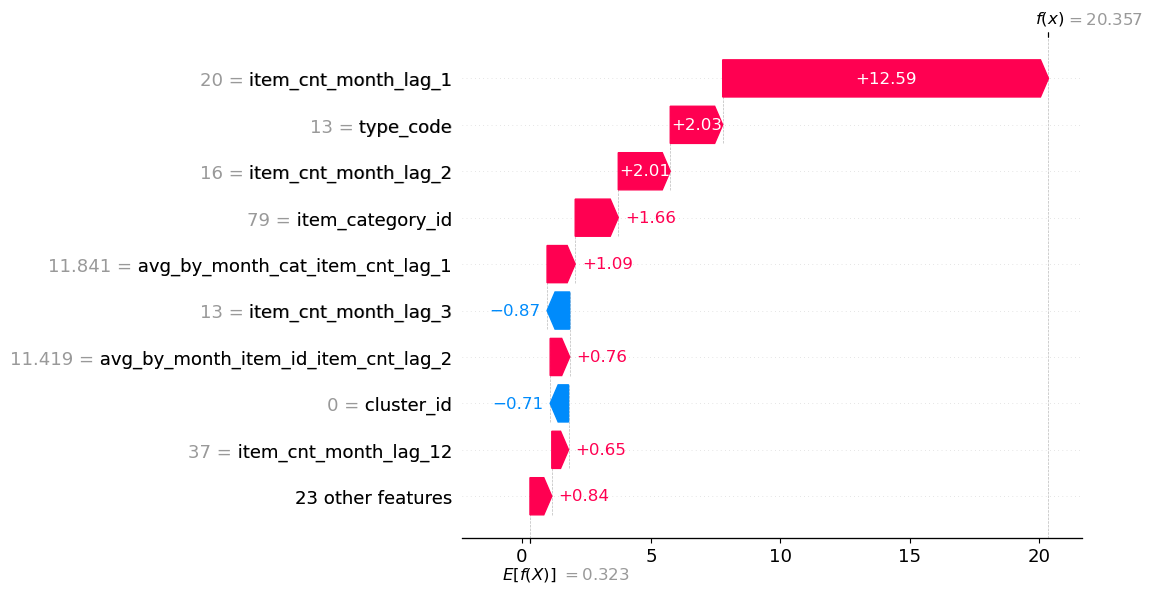

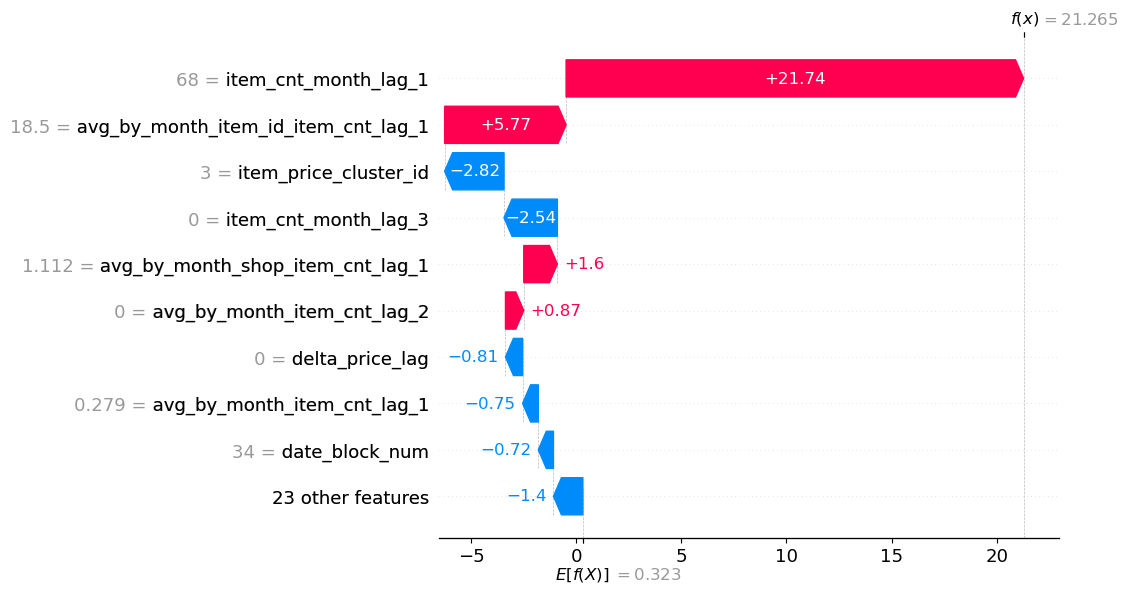

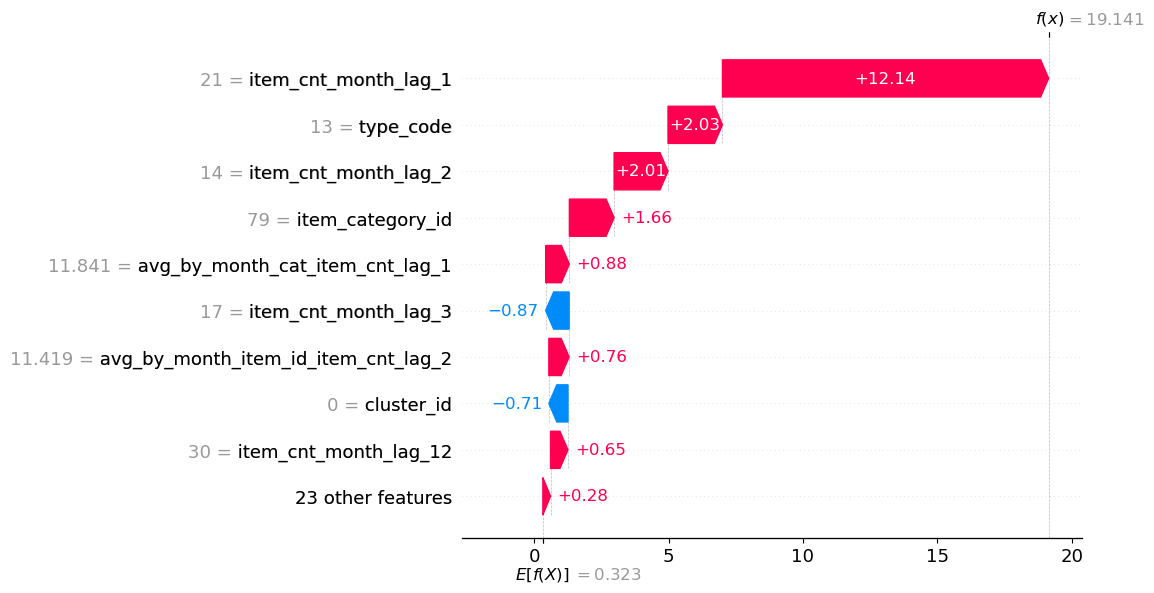

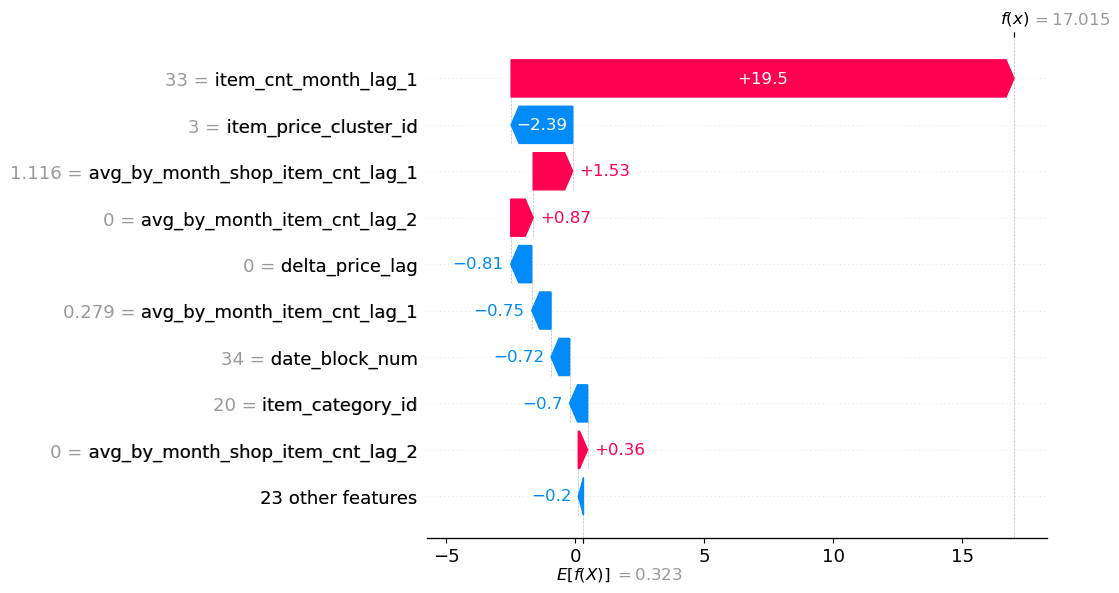

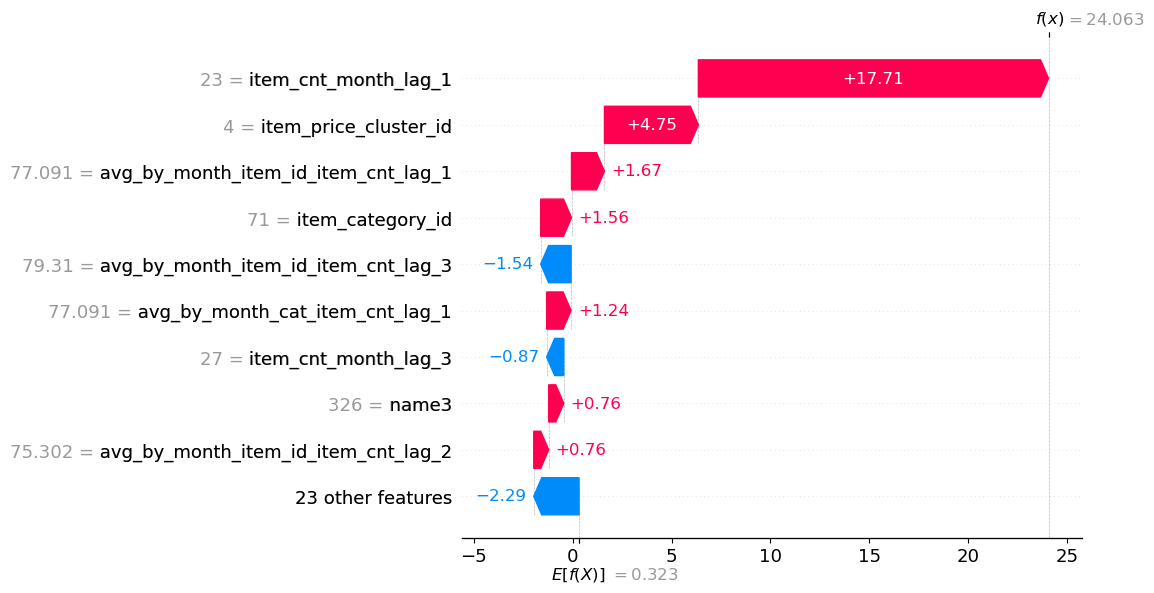

CPU times: total: 7min 20s
Wall time: 3min 37s


,ID,item_cnt_month
0,0,0.40
1,1,0.00
2,2,1.05
3,3,0.23
4,4,0.00
...,...,...
214195,214195,0.21
214196,214196,0.10
214197,214197,0.05
214198,214198,0.04


In [13]:
%%time
CatBoostSHAPTest.evaluate()

### Evaluate all pipeline layers 

In [9]:
%%time

CatBoostPipeline = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(random_state=42, iterations=35, silent=True),
                 check_nans=False,
                 feature_importance_layer=True,
                 selection_sample_size = 100000,
                            
                 hyperparametr_optimization_layer=True,
                 optimizer="Optuna",
                 optimizer_iterations = 50,         
                            
                 explainability_layer=True,
                 error_analysis_layer=True,
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 4.73 s
Wall time: 7.75 s


Iteration: 	1 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	2 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	3 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	4 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	5 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	6 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	7 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	8 / 20
Confirmed: 	10
Tentative: 	3
Rejected: 	19
Iteration: 	9 / 20
Confirmed: 	10
Tentative: 	3
Rejected: 	19
Iteration: 	10 / 20
Confirmed: 	10
Tentative: 	3
Rejected: 	19
Iteration: 	11 / 20
Confirmed: 	10
Tentative: 	3
Rejected: 	19
Iteration: 	12 / 20
Confirmed: 	10
Tentative: 	3
Rejected: 	19
Iteration: 	13 / 20
Confirmed: 	10
Tentative: 	3
Rejected: 	19
Iteration: 	14 / 20
Confirmed: 	10
Tentative: 	3
Rejected: 	19
Iteration: 	15 / 20
Confirmed: 	10
Tentative: 	3
Rejected: 	19
Iteration: 	16 / 20
Confirmed: 	11
Tentative: 	2
Rejected: 	19
Iteratio

[I 2023-10-13 14:57:43,341] A new study created in memory with name: no-name-da5cbe69-f5fa-4035-84a9-4220924e0344


['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_12', 'avg_by_month_item_id_item_cnt_lag_1', 'avg_by_month_item_id_item_cnt_lag_2', 'avg_by_month_item_id_item_cnt_lag_3', 'avg_by_month_shop_item_cnt_lag_1', 'avg_by_month_shop_item_cnt_lag_2', 'avg_by_month_shop_item_cnt_lag_3', 'delta_price_lag']
['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_12', 'avg_by_month_item_id_item_cnt_lag_1', 'avg_by_month_item_id_item_cnt_lag_2', 'avg_by_month_item_id_item_cnt_lag_3', 'avg_by_month_shop_item_cnt_lag_1', 'avg_by_month_shop_item_cnt_lag_2', 'avg_by_month_shop_item_cnt_lag_3', 'delta_price_lag', 'shop_id', 'item_id']
Count of using features 15


[I 2023-10-13 14:59:24,867] Trial 0 finished with value: 1.6378192797488142 and parameters: {'iterations': 98, 'learning_rate': 0.02101202555605017, 'depth': 4, 'l2_leaf_reg': 0.12223202682281946, 'subsample': 0.6913762435148395, 'colsample_bylevel': 0.8290698088895128}. Best is trial 0 with value: 1.6378192797488142.
[I 2023-10-13 15:00:56,723] Trial 1 finished with value: 1.83941760529883 and parameters: {'iterations': 86, 'learning_rate': 0.009821303035014007, 'depth': 4, 'l2_leaf_reg': 0.0034578157973044997, 'subsample': 0.6133605818240785, 'colsample_bylevel': 0.7144356997445612}. Best is trial 0 with value: 1.6378192797488142.
[I 2023-10-13 15:02:27,422] Trial 2 finished with value: 2.261059569792029 and parameters: {'iterations': 109, 'learning_rate': 0.0012269043263233015, 'depth': 4, 'l2_leaf_reg': 0.14551671278978542, 'subsample': 0.45180393050420536, 'colsample_bylevel': 0.15565786494628633}. Best is trial 0 with value: 1.6378192797488142.
[I 2023-10-13 15:06:05,099] Trial 3

[I 2023-10-13 16:13:24,998] Trial 26 finished with value: 1.5733587007673138 and parameters: {'iterations': 225, 'learning_rate': 0.062331630826435995, 'depth': 3, 'l2_leaf_reg': 0.06972369194817712, 'subsample': 0.7667054418375959, 'colsample_bylevel': 0.4270584774804533}. Best is trial 16 with value: 1.5610812002712025.
[I 2023-10-13 16:16:57,144] Trial 27 finished with value: 1.5762326785481158 and parameters: {'iterations': 229, 'learning_rate': 0.037236271762151, 'depth': 3, 'l2_leaf_reg': 0.03812923192597942, 'subsample': 0.882248564153296, 'colsample_bylevel': 0.5120296202567097}. Best is trial 16 with value: 1.5610812002712025.
[I 2023-10-13 16:19:46,867] Trial 28 finished with value: 1.6427173752195023 and parameters: {'iterations': 199, 'learning_rate': 0.015260658387569973, 'depth': 3, 'l2_leaf_reg': 0.3429363498035723, 'subsample': 0.8149952904635204, 'colsample_bylevel': 0.29326339389174794}. Best is trial 16 with value: 1.5610812002712025.
[I 2023-10-13 16:22:33,083] Tria

Best hyperparameters: {'iterations': 246, 'learning_rate': 0.0608303040689687, 'depth': 3, 'l2_leaf_reg': 0.052253849068009936, 'subsample': 0.8332949753085063, 'colsample_bylevel': 0.3650857110195434}
Best RMSE: 1.5610812002712025
['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']
['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_12', 'avg_by_month_item_id_item_cnt_lag_1', 'avg_by_month_item_id_item_cnt_lag_2', 'avg_by_month_item_id_item_cnt_lag_3', 'avg_by_month_shop_item_cnt_lag_1', 'avg_by_month_shop_item_cnt_lag_2', 'avg_by_month_shop_item_cnt_lag_3', 'delta_price_lag', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_month']
['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_12', 'avg_by_month_item_id_item_cnt_lag_1', 'avg_by_month_item_id_item_cnt_lag_2', 'avg_by_month_item_id_item_cnt_lag_3', 'avg_by_month_shop_item_cnt_lag_1', 'avg_by_month_shop_item_cnt_lag_2', 'avg_by_month_shop_ite

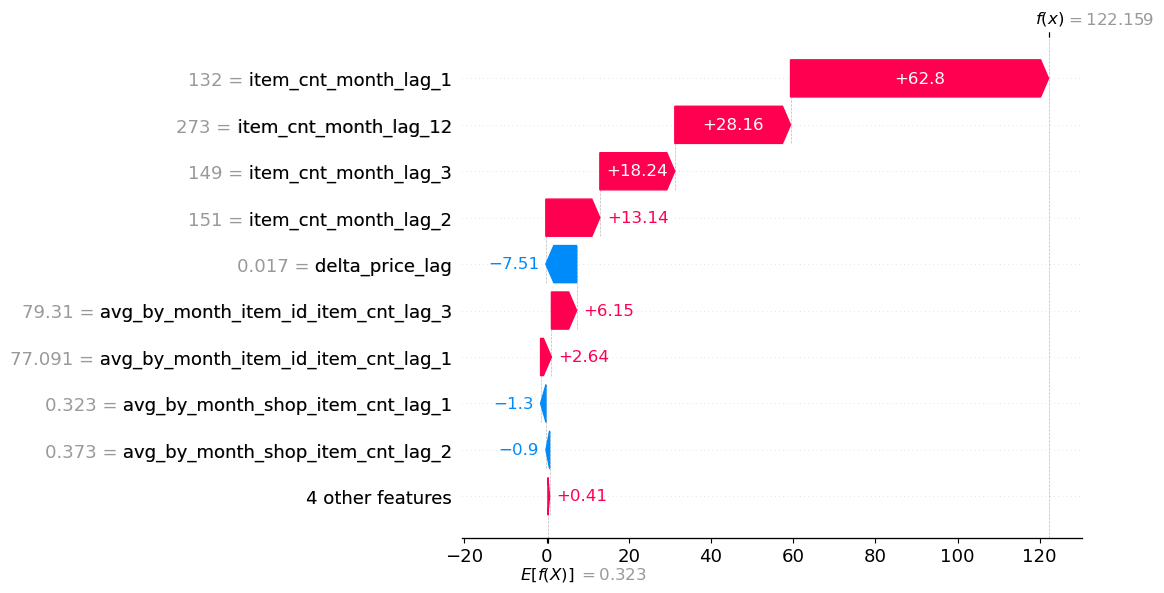

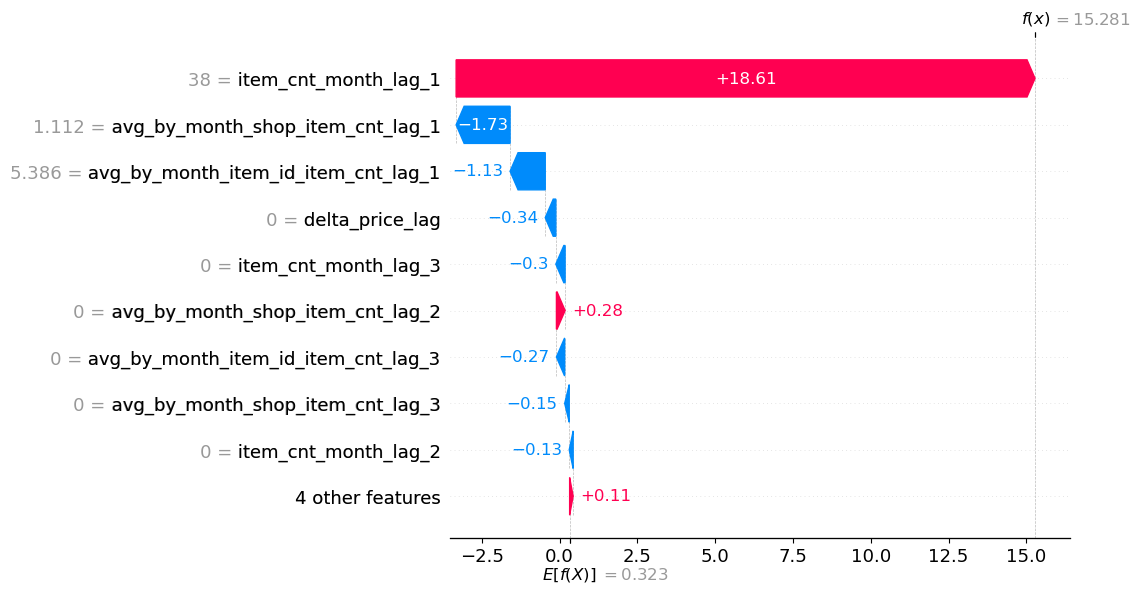

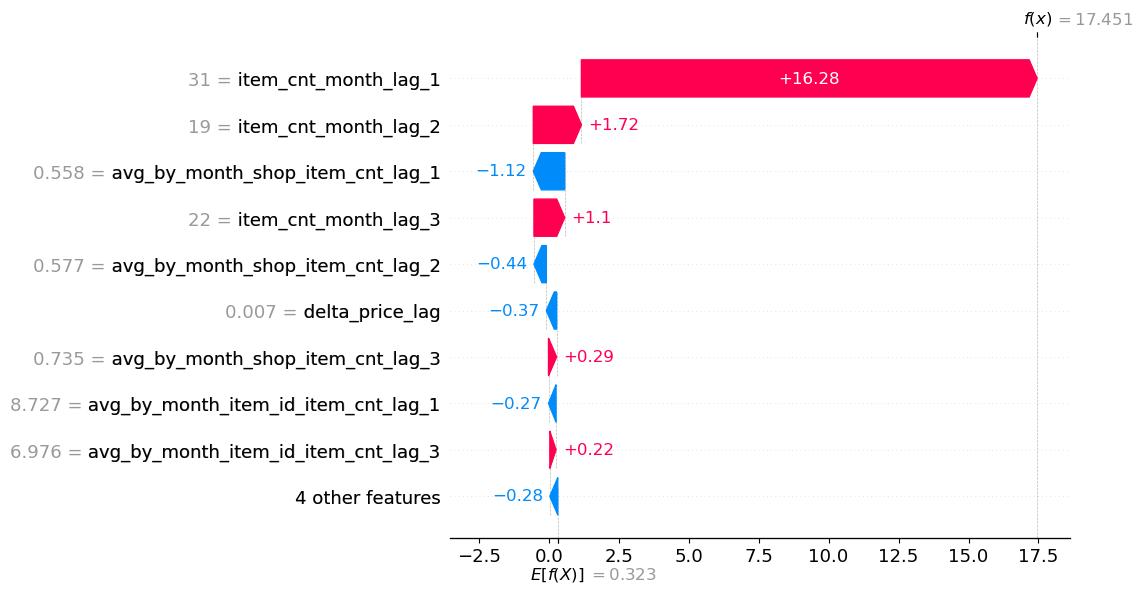

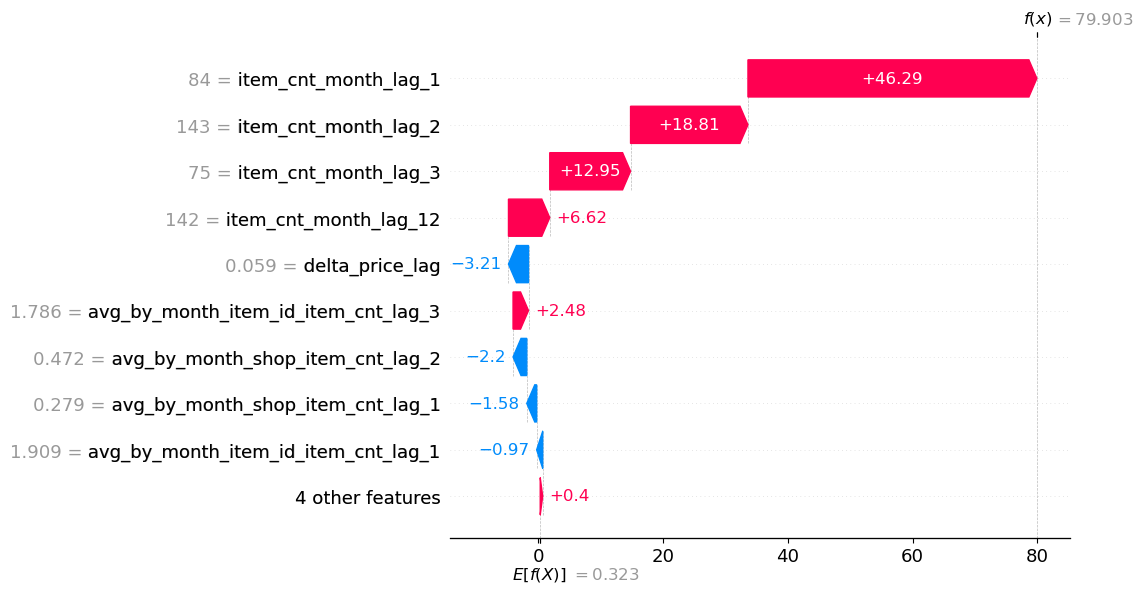

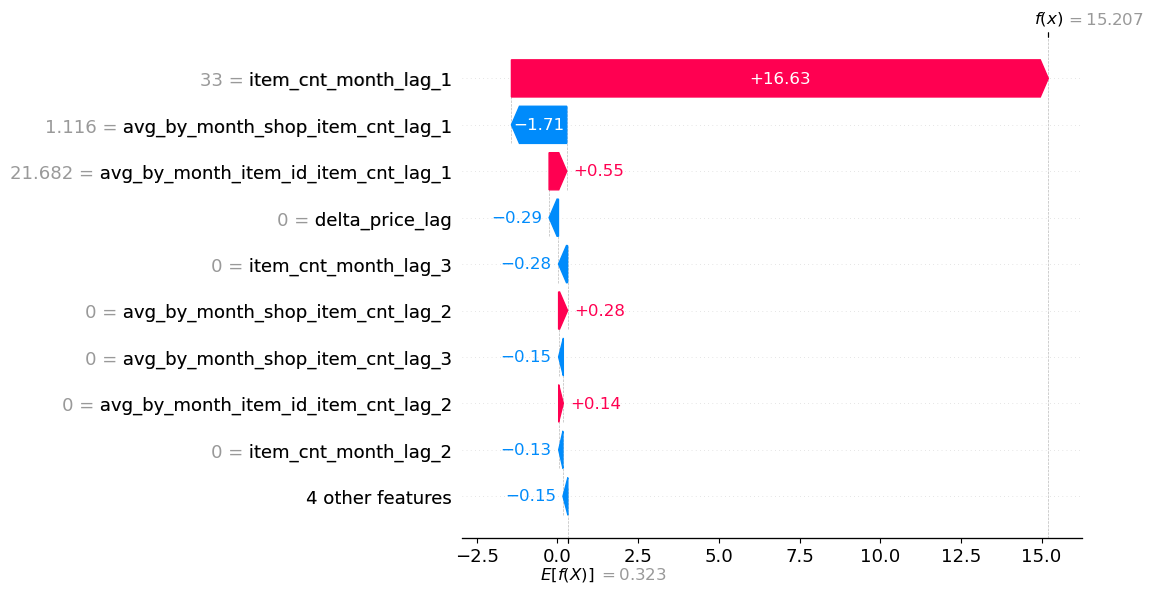

CPU times: total: 7h 2min 5s
Wall time: 2h 38min 33s


In [10]:
%%time
feature_importance_report, error_analysis_report, predictions = CatBoostPipeline.evaluate()

In [17]:
predictions.describe()

,ID,item_cnt_month
count,214200.00,214200.00
mean,107099.50,0.27
std,61834.36,0.70
min,0.00,0.00
25%,53549.75,0.06
50%,107099.50,0.13
75%,160649.25,0.28
max,214199.00,20.00


In [18]:
error_analysis_report['high_error_predictions']

,y_pred,y_test,error,date_block_num,shop_id,item_id,item_category_id,type_code,subtype_code,shop_city,...,avg_by_month_city_item_cnt_lag_1,avg_by_month_cat_item_cnt_lag_1,delta_price_lag,category_cluster_id,item_price_cluster_id,cluster_id,item_shop_first_sale,item_first_sale,error_type_1,error_type_2
6518021,14.00,332.00,318.47,27,25,20949,71,11,59,13,...,0.51,13.27,0.01,4,4,2,24,24,0.04,23.71
6517987,291.00,1.00,291.49,26,42,20949,71,11,59,19,...,0.65,30.67,0.01,4,4,4,23,23,291.00,0.00
6518026,109.00,371.00,261.50,27,31,20949,71,11,59,13,...,0.51,13.27,0.01,4,4,2,24,24,0.29,3.40
6517976,257.00,1.00,257.07,26,27,20949,71,11,59,13,...,0.47,30.67,0.01,4,4,4,23,23,257.00,0.00
6518034,83.00,303.00,219.94,27,42,20949,71,11,59,19,...,0.65,13.27,0.01,4,4,4,24,24,0.27,3.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6518131,69.00,1.00,68.64,29,52,20949,71,11,59,25,...,0.19,80.50,0.01,4,4,3,26,26,69.00,0.01
10811332,5.00,74.00,68.60,27,28,4894,20,6,11,13,...,NaN,NaN,0.00,0,3,4,0,0,0.07,14.80
9775581,73.00,5.00,68.45,27,28,22162,40,8,4,13,...,0.51,0.25,0.04,4,4,4,9,9,14.60,0.07
6517933,197.00,129.00,68.44,25,31,20949,71,11,59,13,...,0.59,90.42,0.01,4,4,2,22,22,1.53,0.65


In [19]:
error_analysis_report['poorly_small_dynamic']

,y_pred,y_test,error,date_block_num,shop_id,item_id,item_category_id,type_code,subtype_code,shop_city,...,avg_by_month_city_item_cnt_lag_1,avg_by_month_cat_item_cnt_lag_1,delta_price_lag,category_cluster_id,item_price_cluster_id,cluster_id,item_shop_first_sale,item_first_sale,error_type_1,error_type_2
6517987,291.00,1.00,291.49,26,42,20949,71,11,59,19,...,0.65,30.67,0.01,4,4,4,23,23,291.00,0.00
6517976,257.00,1.00,257.07,26,27,20949,71,11,59,13,...,0.47,30.67,0.01,4,4,4,23,23,257.00,0.00
6517979,214.00,1.00,214.10,26,31,20949,71,11,59,13,...,0.47,30.67,0.01,4,4,2,23,23,214.00,0.00
6518001,206.00,1.00,206.02,26,57,20949,71,11,59,29,...,0.49,30.67,0.01,4,4,4,23,23,206.00,0.00
6517927,147.00,1.00,147.44,25,25,20949,71,11,59,13,...,0.59,90.42,0.01,4,4,2,22,22,147.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10827809,11.00,1.00,11.20,31,31,14836,65,11,44,13,...,0.51,0.50,-0.04,4,2,2,4,4,11.00,0.09
10966494,11.00,1.00,10.36,31,28,1816,20,6,11,13,...,0.51,0.93,-0.00,0,3,4,1,1,11.00,0.09
10966490,11.00,1.00,10.65,31,22,1816,20,6,11,13,...,0.51,0.93,-0.00,0,3,3,1,1,11.00,0.09
2690064,85.00,8.00,76.57,27,25,22088,83,15,65,13,...,0.51,2.68,0.30,4,1,2,27,27,10.62,0.09


In [20]:
error_analysis_report['poorly_high_dynamic']

,y_pred,y_test,error,date_block_num,shop_id,item_id,item_category_id,type_code,subtype_code,shop_city,...,avg_by_month_city_item_cnt_lag_1,avg_by_month_cat_item_cnt_lag_1,delta_price_lag,category_cluster_id,item_price_cluster_id,cluster_id,item_shop_first_sale,item_first_sale,error_type_1,error_type_2
10861167,1.00,111.00,110.99,27,55,3729,31,6,62,27,...,NaN,NaN,0.00,4,3,3,0,0,0.01,111.00
10708543,1.00,97.00,96.99,25,55,3728,31,6,62,27,...,NaN,NaN,0.00,4,3,3,0,0,0.01,97.00
4362010,1.00,80.00,80.07,25,31,13598,71,11,59,13,...,NaN,NaN,0.00,4,4,2,25,25,0.01,80.00
10916848,1.00,69.00,68.81,28,55,10208,31,6,62,27,...,NaN,NaN,0.00,4,3,3,0,0,0.01,69.00
10869652,1.00,66.00,65.45,28,25,22102,42,9,20,13,...,NaN,NaN,0.00,4,3,2,0,0,0.02,66.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9977186,3.00,31.00,27.58,28,42,3342,20,6,11,19,...,0.74,1.00,0.10,0,3,4,8,8,0.10,10.33
11044038,3.00,31.00,28.43,32,28,3352,23,6,16,13,...,NaN,NaN,0.00,0,3,4,0,0,0.10,10.33
10879277,4.00,41.00,36.73,28,2,10210,20,6,11,0,...,NaN,NaN,0.00,0,3,3,0,0,0.10,10.25
10807350,4.00,41.00,37.02,27,57,3731,30,6,56,29,...,NaN,NaN,0.00,4,3,4,0,0,0.10,10.25


In [21]:
error_analysis_report['percentage_of_big_small_poor_predictions']

'0.051178926755893486 %'

In [22]:
error_analysis_report['items_most_often_errors_occur']

{'small_dynamic': Index([3731, 20949, 7856, 22162], dtype='int64', name='item_id'),
 'big_dynamic': Index([3731, 5361, 15346, 12021, 22102, 2969, 12020, 10210], dtype='int64', name='item_id')}

### Evaluate with only 3 features

In [5]:
%%time

CatBoostPipeline_3_features = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(random_state=42, iterations=35, silent=True),
                 check_nans=False,
                 feature_importance_layer=True,
                 selection_sample_size = 1000,
                            
                 hyperparametr_optimization_layer=True,
                 optimizer="Optuna",
                 optimizer_iterations = 7,         
                            
                 explainability_layer=True,
                 error_analysis_layer=True,
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 3.31 s
Wall time: 3.38 s


Iteration: 	1 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	2 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	3 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	4 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	5 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	6 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	7 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	8 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	9 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	10 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	11 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	12 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	13 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	14 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	15 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	16 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	17 / 

[I 2023-10-24 18:40:38,764] A new study created in memory with name: no-name-5dd085f1-5cec-426c-8df9-b6e14540c724


['item_cnt_month_lag_1', 'item_cnt_month_lag_12', 'avg_by_month_item_id_item_cnt_lag_1']
['item_cnt_month_lag_1', 'item_cnt_month_lag_12', 'avg_by_month_item_id_item_cnt_lag_1', 'shop_id', 'item_id']
Count of using features 7


[I 2023-10-24 18:43:25,507] Trial 0 finished with value: 1.5763180143347744 and parameters: {'iterations': 233, 'learning_rate': 0.020824108297348775, 'depth': 5, 'l2_leaf_reg': 0.0010344773036836767, 'subsample': 0.2796737133444479, 'colsample_bylevel': 0.41348316978710214}. Best is trial 0 with value: 1.5763180143347744.
[I 2023-10-24 18:43:47,145] Trial 1 finished with value: 2.245924297796898 and parameters: {'iterations': 26, 'learning_rate': 0.004080903478846292, 'depth': 5, 'l2_leaf_reg': 0.0046735401111419285, 'subsample': 0.21215481978580564, 'colsample_bylevel': 0.7671439300404848}. Best is trial 0 with value: 1.5763180143347744.
[I 2023-10-24 18:44:33,150] Trial 2 finished with value: 1.9986378074608073 and parameters: {'iterations': 63, 'learning_rate': 0.007620879007515087, 'depth': 4, 'l2_leaf_reg': 0.057672801333131, 'subsample': 0.4269270144845757, 'colsample_bylevel': 0.9377846613530821}. Best is trial 0 with value: 1.5763180143347744.
[I 2023-10-24 18:45:35,692] Trial

Best hyperparameters: {'iterations': 233, 'learning_rate': 0.020824108297348775, 'depth': 5, 'l2_leaf_reg': 0.0010344773036836767, 'subsample': 0.2796737133444479, 'colsample_bylevel': 0.41348316978710214}
Best RMSE: 1.5763180143347744
['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']
['item_cnt_month_lag_1', 'item_cnt_month_lag_12', 'avg_by_month_item_id_item_cnt_lag_1', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_month']
['item_cnt_month_lag_1', 'item_cnt_month_lag_12', 'avg_by_month_item_id_item_cnt_lag_1']
['item_cnt_month_lag_1', 'item_cnt_month_lag_12', 'avg_by_month_item_id_item_cnt_lag_1', 'shop_id', 'item_id']
0:	learn: 2.2352367	total: 244ms	remaining: 56.5s
35:	learn: 1.7882752	total: 9.3s	remaining: 50.9s
70:	learn: 1.6134055	total: 18.1s	remaining: 41.4s
105:	learn: 1.5411259	total: 27.1s	remaining: 32.5s
140:	learn: 1.5072414	total: 36.3s	remaining: 23.7s
175:	learn: 1.4908699	total: 45.4s	remaining: 14.7s
210:	learn: 1.4817348	total: 54.4s	remaining: 5.67s

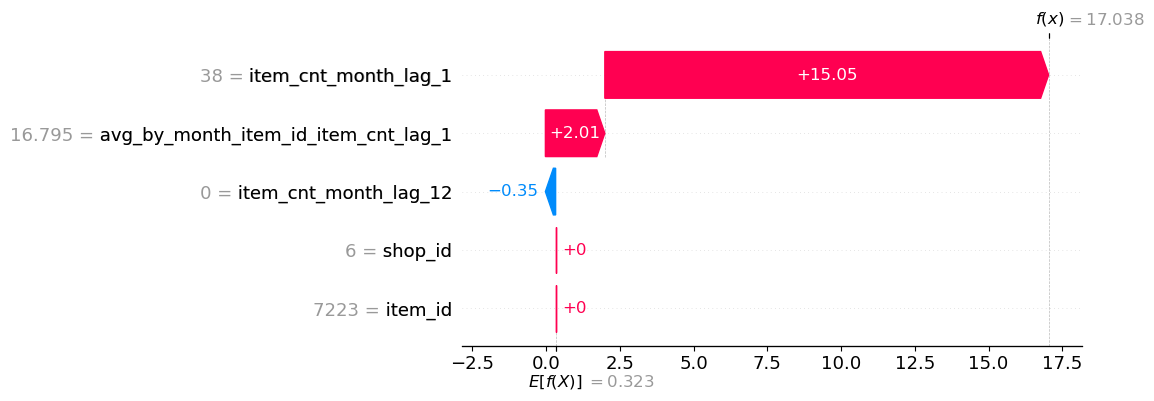

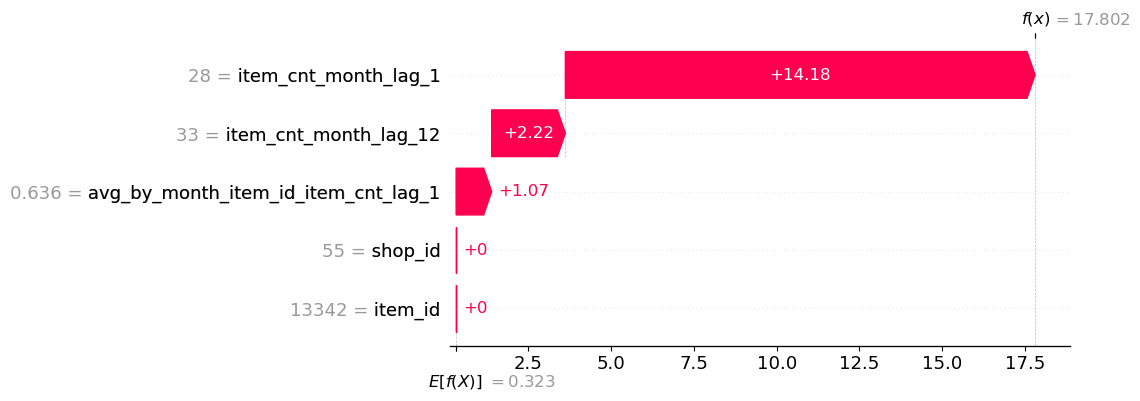

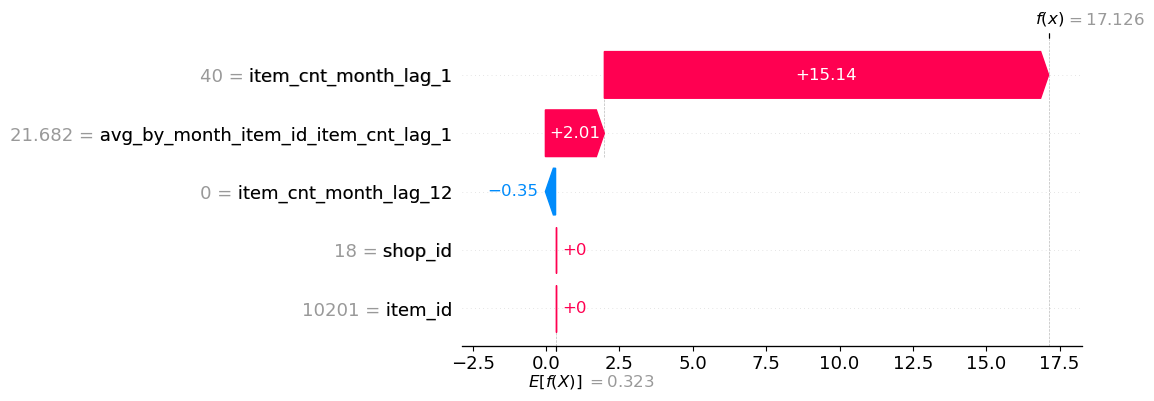

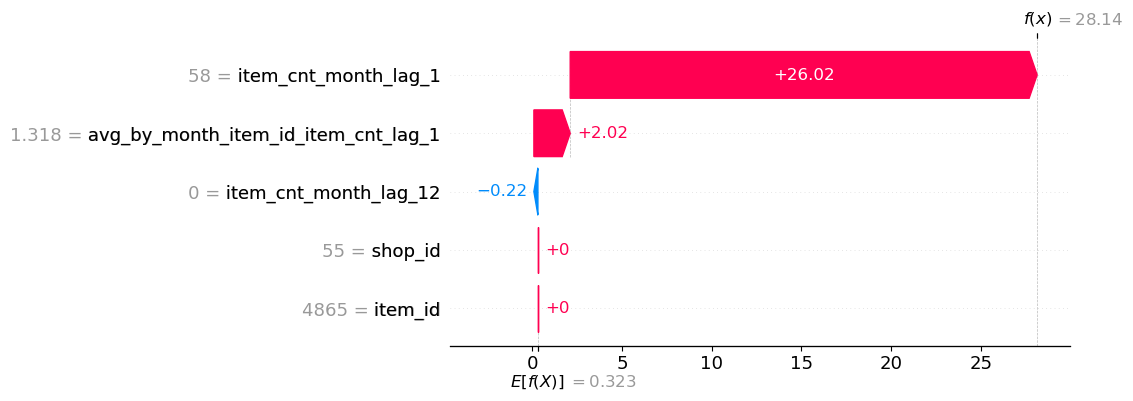

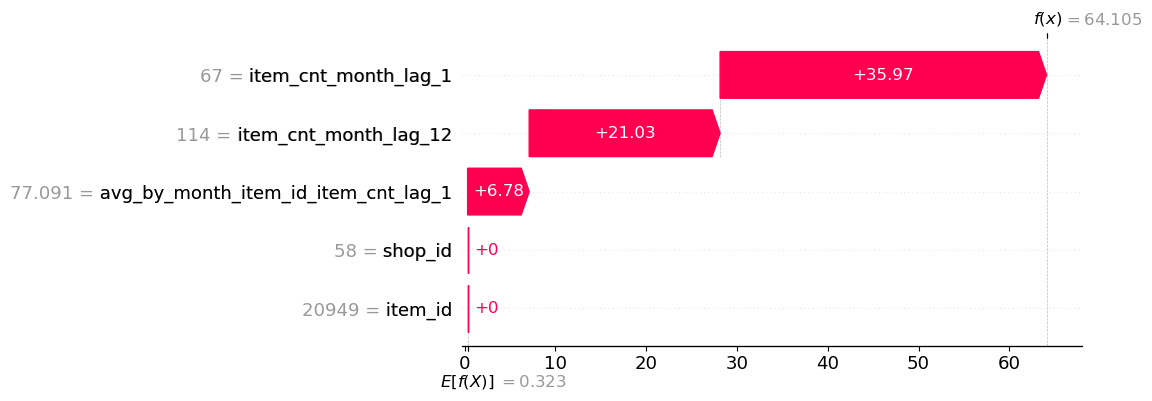

In [6]:
feature_importance_report_3_features, error_analysis_report_3_features, predictions_3_features = CatBoostPipeline_3_features.evaluate()

### Evaluate without feature selection

In [7]:
%%time

CatBoostPipeline_all_features = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(random_state=42, iterations=35, silent=True),
                 check_nans=False,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=True,
                 optimizer="Optuna",
                 optimizer_iterations = 20,         
                 explainability_layer=True,
                 error_analysis_layer=True
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 7.22 s
Wall time: 13.2 s


[I 2023-10-24 18:54:56,461] A new study created in memory with name: no-name-83aac098-414c-4c45-b94a-1ce19560416f


Count of using features 33


[I 2023-10-24 18:55:44,555] Trial 0 finished with value: 1.7950109806935024 and parameters: {'iterations': 28, 'learning_rate': 0.04859802613057927, 'depth': 2, 'l2_leaf_reg': 0.007193640910455611, 'subsample': 0.4443425878693414, 'colsample_bylevel': 0.9086352376643734}. Best is trial 0 with value: 1.7950109806935024.
[I 2023-10-24 18:56:36,158] Trial 1 finished with value: 2.005800242398947 and parameters: {'iterations': 52, 'learning_rate': 0.009625449140795274, 'depth': 4, 'l2_leaf_reg': 0.8286288490676527, 'subsample': 0.33266411409060176, 'colsample_bylevel': 0.2272805639891965}. Best is trial 0 with value: 1.7950109806935024.
[I 2023-10-24 19:00:32,356] Trial 2 finished with value: 1.5068913130057777 and parameters: {'iterations': 214, 'learning_rate': 0.09011447628538287, 'depth': 3, 'l2_leaf_reg': 0.13708527213031985, 'subsample': 0.8895626807982907, 'colsample_bylevel': 0.9968629886800688}. Best is trial 2 with value: 1.5068913130057777.
[I 2023-10-24 19:02:02,772] Trial 3 fi

Best hyperparameters: {'iterations': 178, 'learning_rate': 0.08620667251308946, 'depth': 5, 'l2_leaf_reg': 0.24324358886136965, 'subsample': 0.07880202595953162, 'colsample_bylevel': 0.641350018232518}
Best RMSE: 1.4802046145588341
0:	learn: 2.1666412	total: 229ms	remaining: 40.6s
35:	learn: 1.4492129	total: 8.82s	remaining: 34.8s
70:	learn: 1.3987867	total: 17.6s	remaining: 26.5s
105:	learn: 1.3677257	total: 26.4s	remaining: 17.9s
140:	learn: 1.3481681	total: 35.2s	remaining: 9.23s
175:	learn: 1.3317259	total: 43.8s	remaining: 498ms
177:	learn: 1.3303712	total: 44.3s	remaining: 0us


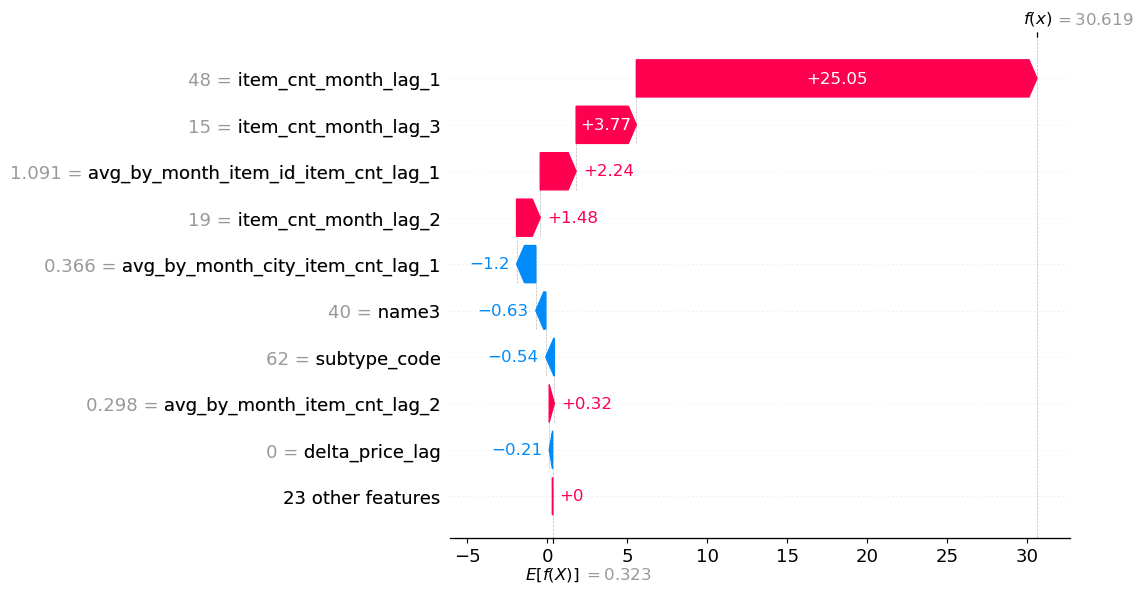

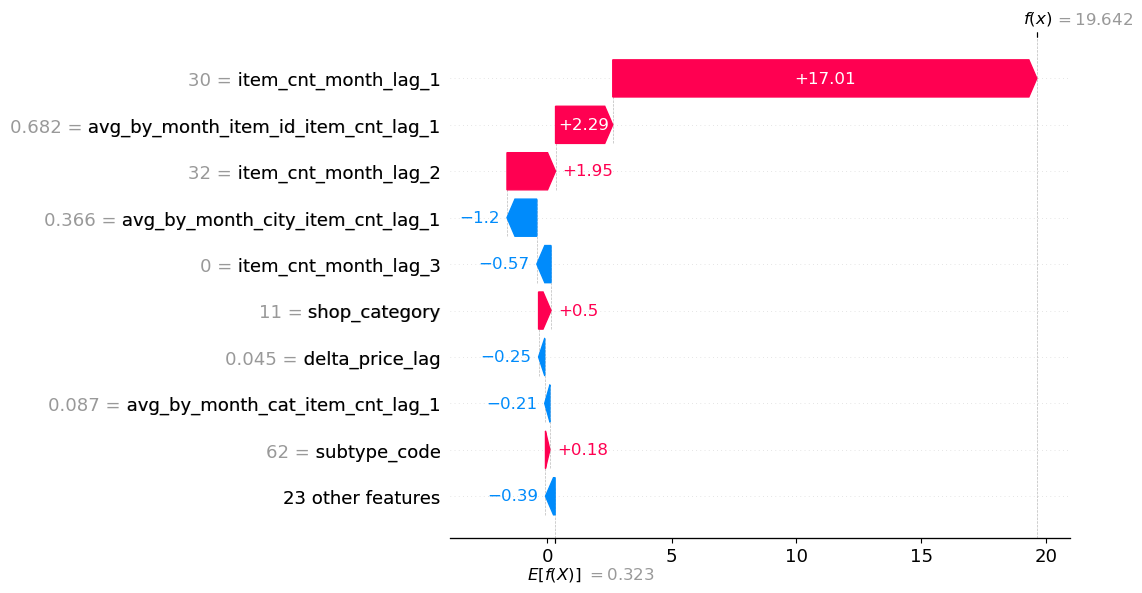

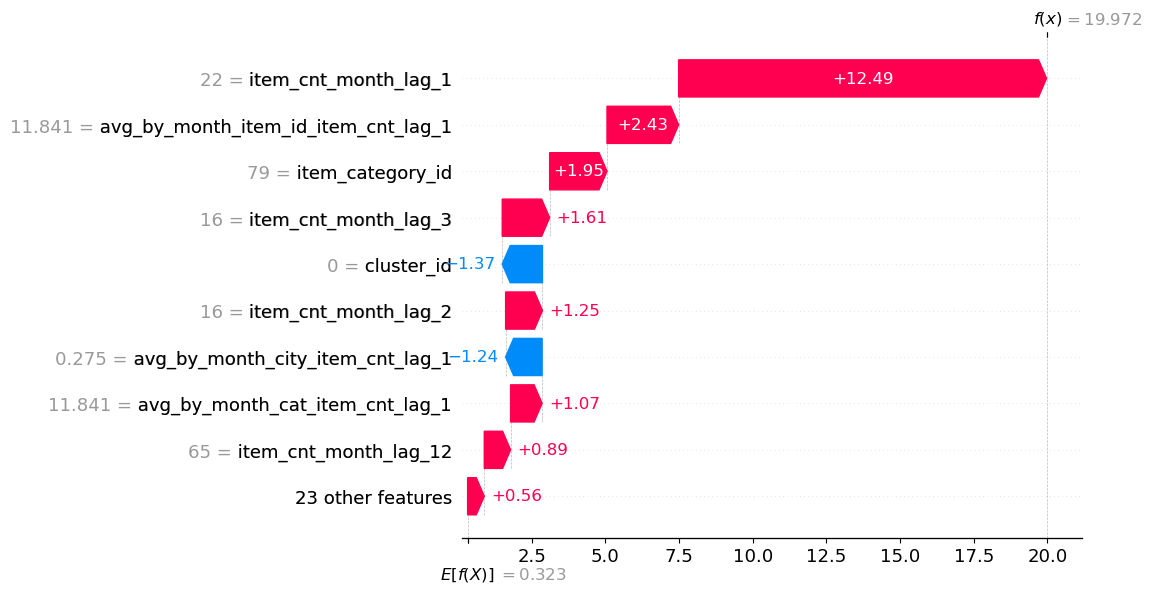

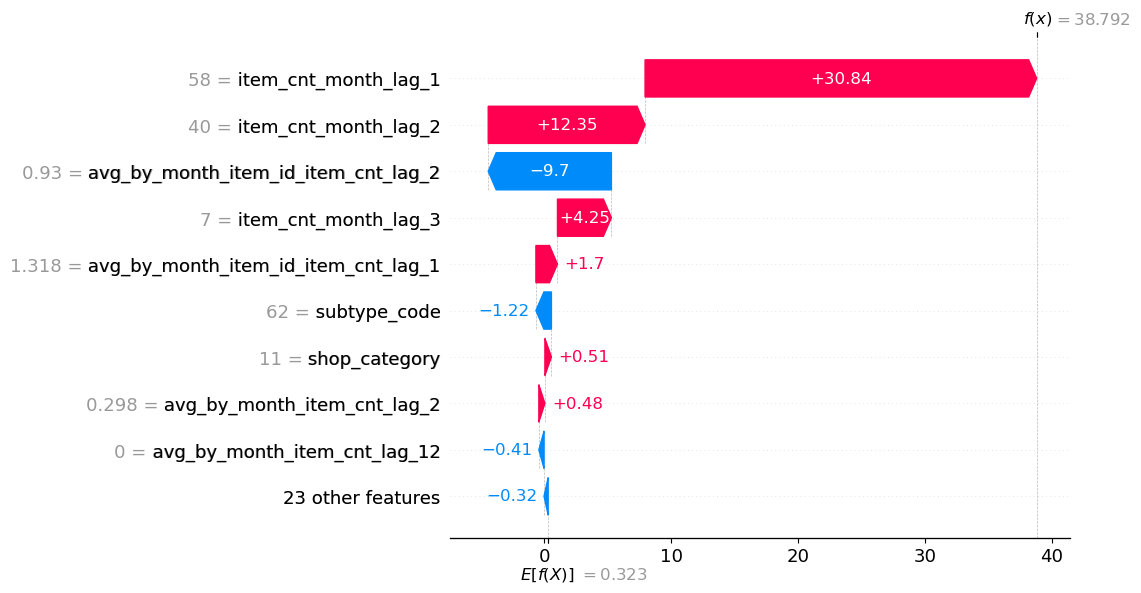

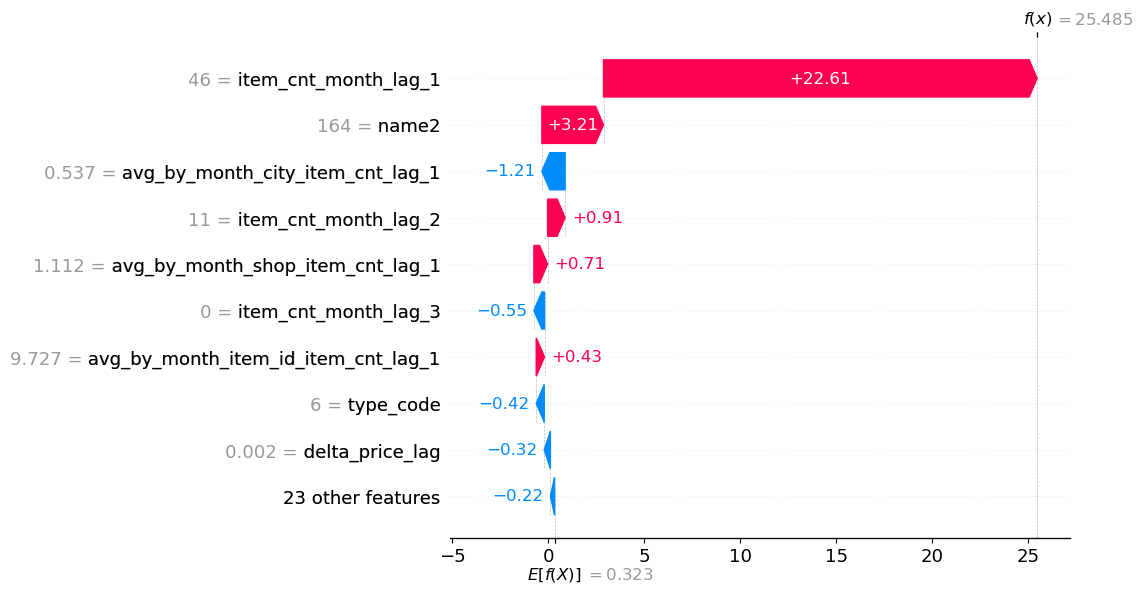

In [8]:
error_analysis_report_all_features, predictions_all_features = CatBoostPipeline_all_features.evaluate()

### Save final predictions

In [11]:
%%time
submission_data = {
    #"advanced_predictions" : predictions,
     "predictions_all_features": predictions_all_features,
     "predictions_3_features": predictions_3_features
}

# get directory path
dirpath = os.getcwd()

# add path to load 
path_to_load = Path(dirpath) / 'data' / 'advanced_submissions'
os.makedirs(path_to_load, exist_ok=True)

# write data
for filename, df in submission_data.items():
    filepath = path_to_load / (filename + ".csv")
    df.to_csv(filepath, index=False)

CPU times: total: 500 ms
Wall time: 542 ms
